<a href="https://colab.research.google.com/github/diogoruivo47/Data-Mining/blob/main/Clustering%20Notebook%20With%20SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex; justify-content: center; align-items: center; padding: 20px;">
    <div style="flex-shrink: 0; display: flex; align-items: center; padding-right: 20px;">
        <img src="https://adnova.novaims.unl.pt/media/22ui3ptm/logo.svg" alt="Nova IMS Logo" style="width: 200px;"/>
    </div>
    <div style="text-align: center;">
        <h1>ABCDEats Inc. - Data Mining Project</h1>
        <h3>Fall Semester 2024-2025</h3>
        <h2>Group 47 Members:</h2>
        <ul style="list-style-type:none; padding: 0;">
            <li>Chiel Groeneveld, 20240662 </li>
            <li>Daan van Holten, 20240681 </li>
            <li>Diogo Ruivo, 20240584 </li>
        </ul>
    </div>
</div>


**Table of Contents** <br>
* [8.Import Libraries](#importlibraries)
* [9.Import Dataset](#importdataset)
* [10.Scaling](#scaling)
    * [10.1 Analysis](#analysis)
* [11.Function Creation](#functions)
* [12.Segmentation](#segmentation)
    * [12.1 Preference-Based Segment](#preference)
    * [12.2 Shopping-Based Segment](#shopping)
    * [12.3 Value-Based Segment](#value)
* [13.Cluster Analysis](#clusteranalysis)
    * [13.1 Centroids](#centroids)
    * [13.2 Profiling](#profiling)
    * [13.3 Merging](#merging)

<hr>
<a class="anchor" id="importlibraries">
    
# 8. Import libraries
    
</a>

In [1]:
!pip install minisom

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

#mathplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colorbar

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#PCA
from sklearn.decomposition import PCA

#Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier

#Clustering Scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

#SOM
from minisom import MiniSom
from matplotlib import colors as mpl_colors
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colorbar import Colorbar

#TSNE
from sklearn.manifold import TSNE

from sklearn.model_selection import ParameterSampler

from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [3]:
# need to install optuna
# !pip install optuna

<hr>
<a class="anchor" id="importdataset">
    
# 9. Import Dataset
    
</a>

In [4]:
df = pd.read_csv('data_clean2.csv')

In [5]:
pd.set_option('display.max_columns', None)
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df_copy = df.copy()
categorical_cols = ['last_promo', 'payment_method', 'customer_region_0', 'customer_region_1', 'customer_region_2', 'customer_region_3']
cat_df = df_copy[categorical_cols].copy()
numerical_cols = df_copy.columns.difference(categorical_cols)
num_df = df_copy[numerical_cols].copy()

<hr>
<a class="anchor" id="scaling">
    
# 10. Scaling
    
</a>

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features with QUANTUM-PRECISE type handling.
    CRITICAL: Convert categorical types before statistical operations!
    """
    # FUNDAMENTAL STEP: Convert DataFrame to float64 with EXTREME PRECISION
    df = df.copy()

    # CRITICAL TYPE CONVERSION WITH VERIFICATION
    for column in df.columns:
        if df[column].dtype.name == 'category':
            df[column] = df[column].astype('float64')

    scaled_df = pd.DataFrame(index=df.index)

    # 1. Binary features
    binary_cols = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                    'CLV_Score', 'RFM_Score' , 'Loyalty']
    for col in binary_cols:
        scaled_df[col] = df[col]

    # 2. CUI features
    cui_cols = [col for col in df.columns if col.startswith('CUI_')]
    for col in cui_cols:
        nonzero_mask = df[col] != 0
        scaled = np.zeros(len(df))
        if nonzero_mask.any():
            nonzero_values = df.loc[nonzero_mask, col].values.reshape(-1, 1)
            scaled[nonzero_mask] = StandardScaler().fit_transform(nonzero_values).ravel()
        scaled_df[col] = scaled

    # 3. Ordinal features
    ordinal_cols = ['is_chain','Orders_Night', 	'Orders_Dawn',	'Orders_Morning',	'Orders_Afternoon'	,'Orders_Evening'	,'Orders_Dusk', 'Age_Group']
    for col in ordinal_cols:
        values = df[col].values.reshape(-1, 1)
        scaled_df[col] = MinMaxScaler().fit_transform(values).ravel()

    # 4. Continuous features
    continuous_cols = ['vendor_count', 'product_count', 'Total_Orders_Per_Client',
                      'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn',
                      'activity']

    for col in continuous_cols:
        values = df[col].values
        if np.std(values) == 0:
            scaled_df[col] = values
            continue

        # MATHEMATICALLY PRECISE skewness handling
        if pd.Series(values, dtype='float64').skew() > 1:
            min_val = values.min()
            if min_val < 0:
                values = values - min_val + 1e-10
            values = np.log1p(values)

        num_df[col] = StandardScaler().fit_transform(values.reshape(-1, 1)).ravel()

    # QUANTUM VALIDATION
    missing_cols = set(df.columns) - set(num_df.columns)
    if missing_cols:
        raise ValueError(f"VIOLATION OF CONSERVATION OF FEATURES: Missing columns: {missing_cols}")

    return num_df

# Execute with SUPERNOVA PRECISION
num_df = scale_features(num_df)

# VALIDATE WITH HADRON COLLIDER PRECISION
print("\nQUANTUM FEATURE VERIFICATION:")
print(f"Input shape: {df.shape}")
print(f"Output shape: {num_df.shape}")
print("\nFEATURE CONSERVATION CHECK:")
print("All features preserved:", set(df.columns) == set(num_df.columns))


QUANTUM FEATURE VERIFICATION:
Input shape: (31737, 48)
Output shape: (31737, 42)

FEATURE CONSERVATION CHECK:
All features preserved: False


<hr>
<a class="anchor" id="analysis">
    
## 10.1 Analysis
    
</a>

In [8]:
num_df.describe()

,Age_Group,CLV_Score,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Items_Per_Order,Loyalty,Orders_Afternoon,Orders_Dawn,Orders_Dusk,Orders_Evening,Orders_Morning,Orders_Night,RFM_Score,Total_Orders_Per_Client,activity,frq,is_chain,mnt,mnt_Per_Order,product_count,rcn,vendor_count
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,31737.000000,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04,3.173700e+04
mean,1.771749,0.066017,4.898412,9.998594,2.308218,0.804975,0.771751,1.438027,0.888566,0.954724,1.638914,3.248795,3.009058,0.715062,3.014186,3.927394,0.845701,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471,-6.332578e-16,0.161565,1.048020,0.331348,0.308851,1.336201,1.078394,0.285219,0.065291,8.597171e-17,-2.865724e-17,-2.865724e-17,2.252891,3.582155e-16,1.862720e-16,8.597171e-17,-5.731447e-17,4.298585e-16
std,0.791278,0.040343,11.667887,23.603496,8.492919,6.442166,3.665578,8.210623,5.272012,5.844075,7.460068,11.272500,10.202599,4.546970,9.789314,15.579992,4.443200,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202,1.000016e+00,0.228829,1.834232,0.946374,0.989525,2.336247,2.093201,0.907566,0.037089,1.000016e+00,1.000016e+00,1.000016e+00,1.952278,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,0.000000,0.011496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,-1.028486e+00,-1.205454e+00,-9.278250e-01,0.000000,-3.453503e+00,-1.522614e+00,-1.437495e+00,-1.174464e+00,-1.177017e+00
25%,1.000000,0.030806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031640,-6.457117e-01,-1.103443e+00,-7.265809e-01,1.000000,-6.840819e-01,-7.672763e-01,-7.825958e-01,-8.257126e-01,-1.177017e+00
50%,2.000000,0.055885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.909657e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.056626,-2.629377e-01,-4.932618e-02,-5.260947e-01,2.000000,1.415649e-02,-2.610392e-01,-3.179376e-01,-3.025859e-01,-3.174828e-01
75%,2.000000,0.093041,5.710000,11.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.088916e-01,0.333333,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.096610,5.026102e-01,9.027790e-01,8.017729e-01,3.000000,7.354295e-01,4.942987e-01,8.016196e-01,6.128859e-01,7.654022e-01
max,5.000000,0.186393,280.210000,896.710000,229.220000,326.100000,219.660000,739.730000,230.070000,255.810000,309.070000,468.330000,706.140000,275.110000,366.080000,454.450000,136.380000,16.000000,17.000000,15.000000,17.000000,16.000000,20.000000,20.000000,2.542052e+00,0.833333,42.000000,21.000000,43.000000,49.000000,58.000000,20.000000,0.194064,2.033706e+00,1.854884e+00,2.342243e+00,6.000000,1.587099e+00,2.386661e+00,1.81693

In [9]:
# Calculate the Spearman correlation matrix
spearman_corr = num_df.corr(method='spearman')

# Display the correlation matrix
spearman_corr

,Age_Group,CLV_Score,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Items_Per_Order,Loyalty,Orders_Afternoon,Orders_Dawn,Orders_Dusk,Orders_Evening,Orders_Morning,Orders_Night,RFM_Score,Total_Orders_Per_Client,activity,frq,is_chain,mnt,mnt_Per_Order,product_count,rcn,vendor_count
Age_Group,1.000000,0.008029,0.005723,0.003923,-0.005109,0.005333,-0.002110,0.002340,-0.005886,0.008266,-0.002564,0.003228,-0.006198,0.002167,0.001896,-0.000755,-0.000782,0.014155,0.002188,0.002543,0.008337,-0.002040,-0.002210,0.003904,0.003364,0.009922,0.006926,-0.002274,0.001361,0.001311,-0.001494,0.000482,0.006676,0.008039,0.006400,-0.003050,0.004309,0.007902,0.002042,0.008210,-0.012532,0.003960
CLV_Score,0.008029,1.000000,0.009025,0.074601,-0.011513,0.059109,-0.044897,0.007215,0.028317,0.028893,0.017270,0.003967,0.042438,-0.021215,0.015072,0.068899,0.017729,0.041674,0.052926,0.063361,0.094587,0.100607,0.016857,-0.004533,0.125428,-0.019965,0.008237,0.043632,-0.022636,-0.041549,0.050462,0.036009,0.989184,-0.106557,-0.183989,0.574515,-0.086399,0.119324,0.223013,-0.043445,-0.406842,-0.107176
CUI_American,0.005723,0.009025,1.000000,0.007332,-0.015387,0.065179,-0.000643,-0.010538,0.010316,0.003491,0.003923,0.057667,0.043318,-0.029172,0.026228,0.012435,0.029675,0.174074,0.175870,0.178959,0.189133,0.197675,0.187075,0.184536,0.031683,0.151400,0.169882,0.084221,0.086375,0.151380,0.187600,0.118107,-0.014306,0.338085,0.296255,-0.105781,0.330598,0.280951,-0.013398,0.309508,-0.171845,0.351875
CUI_Asian,0.003923,0.074601,0.007332,1.000000,0.034078,-0.012756,-0.103489,-0.015550,0.075037,0.010005,-0.096040,-0.167585,0.040372,-0.082444,-0.131623,0.130413,-0.060153,0.162734,0.157037,0.156814,0.138672,0.104094,0.112397,0.118334,0.182380,0.045344,0.014751,0.344037,-0.053403,-0.149691,0.244490,0.328527,0.045457,0.252635,0.213526,-0.084808,0.094222,0.454214,0.339130,0.279956,-0.157729,0.297233
CUI_Beverages,-0.005109,-0.011513,-0.015387,0.034078,1.000000,-0.042555,0.094204,0.081135,0.098443,-0.008512,-0.034951,-0.143470,-0.000907,0.094591,0.009404,0.050634,-0.030654,0.127943,0.124477,0.115184,0.113511,0.099975,0.102991,0.093854,0.059450,0.000509,0.109414,0.208893,0.114618,-0.043844,0.145186,0.128476,-0.023860,0.198629,0.171857,-0.058217,0.265690,0.135799,-0.060123,0.193098,-0.085882,0.250485
CUI_Cafe,0.005333,0.059109,0.065179,-0.012756,-0.042555,1.000000,-0.009093,-0.000914,-0.016337,0.105053,0.062099,0.121947,0.062444,-0.008576,0.131633,-0.049492,0.083459,0.114885,0.114361,0.116879,0.125629,0.117237,0.103285,0.118858,0.040379,0.111052,0.123698,0.030773,0.023953,0.144162,0.179790,-0.063906,0.050970,0.171584,0.135666,0.006320,0.165666,0.141880,-0.030471,0.167178,-0.103567,0.173375
CUI_Chicken_Dishes,-0.002110,-0.044897,-0.000643,-0.103489,0.094204,-0.009093,1.000000,0.157234,0.025076,-0.012814,0.081248,-0.035988,0.008776,0.210156,0.177586,-0.063354,0.046587,0.137344,0.133062,0.134775,0.132748,0.127351,0.125016,0.132129,0.012387,0.068544,0.179475,-0.107102,0.249155,0.233228,0.075279,-0.062044,-0.047217,0.219054,0.183155,-0.036839,0.297081,-0.027079,-0.334315,0.200558,-0.091091,0.247379
CUI_Chinese,0.002340,0.007215,-0.010538,-0.015550,0.081135,-0.000914,0.157234,1.000000,0.026401,0.011930,-0.000944,-0.054318,0.050209,0.215469,0.126193,-0.021589,0.026105,0.137257,0.145548,0.141348,0.140331,0.126429,0.132369,0.148394,0.077362,0.079259,0.146449,-0.000133,0.168401,0.156189,0.115020,0.023641,-0.001517,0.229416,0.185766,-0.024667,0.232578,0.095171,-0.167759,0.228505,-0.109997,0.251667
CUI_Desserts,-0.005886,0.028317,0.010316,0.075037,0.098443,-0.016337,0.025076,0.026401,1.000000,0.009390,-0.023756,-0.090356,0.012118,0.007400,-0.023845,0.085192,-0.029708,0.079590,0.077414,0.083423,0.075318,0.058157,0.069065,0.076604,0.045257,-0.010637,0.081983,0.170041,0.031799,-0.053549,0.109716,0.100097,

In [10]:
# Get correlations above 0.5 (excluding self-correlations)
strong_corrs = [(i, j, spearman_corr.loc[i, j])
                for i in spearman_corr.index
                for j in spearman_corr.columns
                if abs(spearman_corr.loc[i, j]) > 0.7 and i < j]

# Print sorted results
print("Correlations above 0.5:")
for var1, var2, corr in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} - {var2}: {corr:.3f}")

Correlations above 0.5:
CLV_Score - RFM_Score: 0.989
Total_Orders_Per_Client - product_count: 0.947
Total_Orders_Per_Client - vendor_count: 0.886
product_count - vendor_count: 0.842
Total_Orders_Per_Client - activity: 0.832
mnt - product_count: 0.795
activity - product_count: 0.784
activity - vendor_count: 0.756
Total_Orders_Per_Client - is_chain: 0.727
activity - frq: -0.718
is_chain - vendor_count: 0.705


In [11]:
num_df.columns

Index(['Age_Group', 'CLV_Score', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai',
       'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'Items_Per_Order', 'Loyalty', 'Orders_Afternoon', 'Orders_Dawn',
       'Orders_Dusk', 'Orders_Evening', 'Orders_Morning', 'Orders_Night',
       'RFM_Score', 'Total_Orders_Per_Client', 'activity', 'frq', 'is_chain',
       'mnt', 'mnt_Per_Order', 'product_count', 'rcn', 'vendor_count'],
      dtype='object')

<hr>
<a class="anchor" id="functions">
    
# 11. Functions
    
</a>

#### PCA

In [12]:
def pca(df_pca):
    # Initialize PCA
    pca = PCA()
    pca_feat = pca.fit_transform(df_pca)

    # Calculate cumulative explained variance
    explained_variance = pca.explained_variance_
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    # Find the number of components needed to reach 80% variance
    num_components = np.argmax(cumulative_explained_variance_ratio >= 0.8) + 1

    # Add PCA components explaining 80% variance back to DataFrame
    selected_pcas = pca_feat[:, :num_components]
    for i in range(num_components):
        df_pca[f'PCA_{i+1}'] = selected_pcas[:, i]

    # Plotting
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), facecolor='white')

    # Plot 1: Scree Plot (Eigenvalues)
    ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 'ro-', linewidth=2, markersize=8, label='Eigenvalues')
    ax1.set_title("Scree Plot (Eigenvalues)", fontsize=18, pad=15, fontweight='bold')
    ax1.set_xlabel("Principal Components", fontsize=14)
    ax1.set_ylabel("Eigenvalue", fontsize=14)
    ax1.set_xticks(range(1, len(explained_variance) + 1, 2))
    ax1.set_xticklabels(range(1, len(explained_variance) + 1, 2), fontsize=12)
    ax1.set_facecolor('white')
    ax1.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax1.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility
    ax1.legend(fontsize=12, loc='upper right')

    # Plot 2: Explained Variance as a Bar Chart
    ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio,
            color='#1f77b4', alpha=0.7, label='Explained Variance (%)', width=0.8)  # Customize bar color
    ax2.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio,
             'ro-', linewidth=2, markersize=8, label='Cumulative Variance (%)')

    # Customize the plot
    ax2.set_title("Variance Explained by Principal Components", fontsize=18, pad=15, fontweight='bold')
    ax2.set_xlabel("Principal Components", fontsize=14)
    ax2.set_ylabel("Variance (%)", fontsize=14)
    ax2.set_xticks(range(1, len(explained_variance_ratio) + 1, 2))  # Show every 2nd PC for clarity
    ax2.set_xticklabels(range(1, len(explained_variance_ratio) + 1, 2), fontsize=12)
    ax2.set_facecolor('white')
    ax2.grid(True, color='black', linestyle='-', linewidth=0.8, alpha=0.4)  # Lighter grid lines
    ax2.tick_params(axis='both', which='both', colors='black', width=1)  # Black ticks with better visibility

    # Add legend
    ax2.legend(fontsize=12, loc='upper left')

    # Adjust layout to ensure everything fits and has proper padding
    plt.tight_layout(pad=4.0)

    # Show plot
    plt.show()

    return df_pca

In [13]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: #ffbdbd'
    elif val > 0.45:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

#### Feature Selection

In [14]:
def analyze_feature_importance(df):
   # Get cluster labels
   kmeans = KMeans(n_clusters=3, random_state=42)
   labels = kmeans.fit_predict(df)

   # Train RF classifier on clusters
   rf = RandomForestClassifier(random_state=42)
   rf.fit(df, labels)

   # Get feature importance
   importance = pd.DataFrame({
       'feature': df.columns,
       'importance': rf.feature_importances_
   }).sort_values('importance', ascending=False)

   return importance

### Clustering

#### KMeans

In [15]:
def clustering_kmeans(df, k_range=(3, 11), random_state=42):

    # Ensure input is a NumPy array
    np_array = df.values if isinstance(df, pd.DataFrame) else df

    # Clustering metrics
    metrics = []
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)
        labels = kmeans.fit_predict(np_array)

        # Calculate SSE
        sse = np.sum((np_array - kmeans.cluster_centers_[labels]) ** 2)

        # Calculate R2
        r2 = r2_score(np_array, kmeans.cluster_centers_[labels])

        metrics.append({
            'k': k,
            'silhouette': silhouette_score(np_array, labels),
            'calinski': calinski_harabasz_score(np_array, labels),
            'davies': davies_bouldin_score(np_array, labels),
            'inertia': kmeans.inertia_,
            'sse': sse,
            'r2': r2
        })

    # Print metrics
    for m in metrics:
        print(f"\nk={m['k']}:")
        print(f"Silhouette: {m['silhouette']:.3f}")
        print(f"Calinski-Harabasz: {m['calinski']:.2f}")
        print(f"Davies-Bouldin: {m['davies']:.2f}")
        print(f"SSE: {m['sse']:.2f}")
        print(f"R2: {m['r2']:.3f}")
        print(f"Inertia: {m['inertia']:.2f}")

    # Select best k based on Silhouette score
    best_k = max(metrics, key=lambda x: x['silhouette'])['k']
    kmeans_final = KMeans(n_clusters=best_k, init='k-means++', random_state=random_state)
    labels = kmeans_final.fit_predict(np_array)

    # Update DataFrame with cluster labels
    if isinstance(df, pd.DataFrame):
        df['cluster_k'] = labels

    # T-SNE visualization
    tsne = TSNE(random_state=random_state)
    embedding = tsne.fit_transform(np_array)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # T-SNE plot
    scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
    ax1.set_title(f'T-SNE visualization of {best_k} clusters')
    plt.colorbar(scatter, ax=ax1)

    # Elbow plot
    ax2.plot(range(k_range[0], k_range[1]), [m['inertia'] for m in metrics], 'bo-')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Inertia')
    ax2.set_title('Elbow Method')

    plt.tight_layout()
    plt.show()

#### Hierarchical

In [16]:
def plot_dendrogram(df, method='ward', y_threshold=200):
    # Store 'cluster_k' if it exists
    cluster_k = None
    if 'cluster_k' in df.columns:
        cluster_k = df['cluster_k']
        df = df.drop(columns=['cluster_k'])

    # Compute the linkage matrix
    linkage_matrix = linkage(df, method=method)

    # Set up the plotting environment
    sns.set()
    fig = plt.figure(figsize=(11, 5))

    # Plot the dendrogram
    dendrogram(
        linkage_matrix,
        truncate_mode='level',
        p=5,
        color_threshold=y_threshold,
        above_threshold_color='k'
    )

    # Add a horizontal line for the threshold
    plt.hlines(y_threshold, 0, plt.xlim()[1], colors="r", linestyles="dashed")

    # Customize the plot
    plt.title(f'Hierarchical Clustering Dendrogram: {method.title()} Linkage', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)', fontsize=13)
    plt.ylabel(f'{method.title()} Distance', fontsize=13)
    plt.show()

    # Get the clusters at the given y_threshold
    clusters = fcluster(linkage_matrix, y_threshold, criterion='distance')
    df['cluster_h'] = clusters

    # Add 'cluster_k' back if it existed
    if cluster_k is not None:
        df['cluster_k'] = cluster_k

    # Return the number of clusters formed and the updated DataFrame
    n_clusters = len(set(clusters))
    return n_clusters, df

In [17]:
def hierarchical_clustering_scores(data, n_clusters):

    # Perform Hierarchical Clustering using Ward's method
    linkage_matrix = linkage(data, method='ward')

    # Assign clusters using the fcluster function
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Calculate the clustering metrics
    silhouette = silhouette_score(data, hierarchical_labels)
    calinski = calinski_harabasz_score(data, hierarchical_labels)
    davies = davies_bouldin_score(data, hierarchical_labels)

    # Return the results as a dictionary
    return {
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    }

#### Choosing the clustering method

In [18]:
def chosen_method(df: pd.DataFrame, drop_column: str) -> pd.DataFrame:
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Validate the drop_column argument
    if drop_column not in ['cluster_h', 'cluster_k']:
        raise ValueError("Invalid drop_column value. Must be 'cluster_h' or 'cluster_k'.")

    # Ensure either 'cluster_h' or 'cluster_k' exists in the DataFrame
    if 'cluster_h' not in df.columns and 'cluster_k' not in df.columns:
        raise ValueError("Neither 'cluster_h' nor 'cluster_k' columns are present in the DataFrame.")

    # Drop the specified column if it exists
    if drop_column in df.columns:
        df.drop(columns=[drop_column], inplace=True)

    # Rename the remaining column to 'cluster' (if it exists)
    if 'cluster_h' in df.columns:
        df.rename(columns={'cluster_h': 'cluster'}, inplace=True)
    elif 'cluster_k' in df.columns:
        df.rename(columns={'cluster_k': 'cluster'}, inplace=True)

    return df

<hr>
<a class="anchor" id="segmentation">
    
# 12. Segmentation
    
</a>

In [19]:
df

,vendor_count,product_count,is_chain,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity,Loyalty,Age_Group,CLV_Score,RFM_Score,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,customer_region_0,customer_region_1,customer_region_2,customer_region_3
0,2.0,5.0,1.0,1,2,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,28.88,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,2.0,28.88,14.440,2.25,1.000000,90.0,2.0,0.0,1,0.092846,0.097455,0,0,0,0,2,0,0.0,1.0,0.0,0.0
1,2.0,2.0,2.0,2,2,12.82,6.39,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,2.0,19.21,9.600,1.00,1.000000,90.0,2.0,0.0,0,0.090596,0.095409,0,0,2,0,0,0,0.0,0.0,0.0,1.0
2,1.0,2.0,2.0,2,0,9.20,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,2.0,9.20,4.600,1.00,1.000000,90.0,2.0,0.5,3,0.088267,0.093292,0,0,2,0,0,0,0.0,0.0,1.0,0.0
3,2.0,3.0,1.0,1,2,0.00,13.70,0.00,0.0,0.0,0.0,0.00,0.0,17.86,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,2.0,31.56,15.780,1.50,0.666667,89.0,3.0,0.0,2,0.066010,0.068898,0,0,1,1,0,0,0.0,0.0,1.0,0.0
4,2.0,5.0,0.0,0,2,14.57,40.87,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,2.0,55.44,24.695,2.25,0.666667,89.0,3.0,0.0,1,0.071566,0.073949,0,0,2,0,0,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31732,1.0,1.0,1.0,3,2,0.00,0.00,18.04,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,18.04,18.040,1.00,1.000000,0.0,1.0,0.0,2,0.186393,0.176038,0,0,0,1,0,0,0.0,0.0,0.0,1.0
31733,1.0,1.0,0.0,1,2,18.04,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,18.04,18.040,1.00,1.000000,0.0,1.0,0.0,2,0.186393,0.176038,0,0,0,0,1,0,0.0,0.0,0.0,1.0
31734,1.0,1.0,1.0,0,2,0.00,0.00,0.00,0.0,0.0,0.0,17.79,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,17.79,17.790,1.00,1.000000,0.0,1.0,0.0,1,0.186393,0.175985,0,1,0,0,0,0,0.0,0.0,0.0,1.0
31735,1.0,1.0,0.0,2,2,0.00,12.03,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,12.03,12.030,1.00,1.000000,0.0,1.0,0.0,2,0.186393,0.174767,0,0,1,0,0,0,0.0,0.0,0.0,1.0


In [20]:
value_engagement_metrics = ['mnt', 'activity', 'frq', 'rcn', 'CLV_Score']

preference_metrics = ['CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Thai', 'CUI_Street_Food/Snacks']
shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk'
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3'
]

In [21]:
num_df

,Age_Group,CLV_Score,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Items_Per_Order,Loyalty,Orders_Afternoon,Orders_Dawn,Orders_Dusk,Orders_Evening,Orders_Morning,Orders_Night,RFM_Score,Total_Orders_Per_Client,activity,frq,is_chain,mnt,mnt_Per_Order,product_count,rcn,vendor_count
0,1,0.092846,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,28.88,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,2.542052,0.0,0,0,0,2,0,0,0.097455,-0.645712,-1.171450,1.663218,1.0,0.217004,0.738578,0.336961,2.748987,-0.317483
1,0,0.090596,12.82,6.39,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,-0.850231,0.0,0,0,0,0,2,0,0.095409,-0.645712,-1.171450,1.663218,2.0,-0.248614,-0.039259,-0.782596,2.748987,-0.317483
2,3,0.088267,9.20,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,-0.850231,0.5,0,0,0,0,2,0,0.093292,-0.645712,-1.171450,1.663218,2.0,-1.062873,-0.842810,-0.782596,2.748987,-1.177017
3,2,0.066010,0.00,13.70,0.00,0.0,0.0,0.0,0.00,0.0,17.86,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0.708892,0.0,1,0,0,0,1,0,0.068898,-0.645712,-1.137446,0.959366,1.0,0.319289,0.953930,-0.317938,2.705393,-0.317483
4,1,0.071566,14.57,40.87,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,2.542052,0.0,0,0,0,0,2,0,0.073949,-0.645712,-1.137446,0.959366,0.0,0.974342,2.386661,0.336961,2.705393,-0.317483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31732,2,0.186393,0.00,0.00,18.04,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,-0.850231,0.0,1,0,0,0,0,0,0.176038,-1.028486,-1.205454,1.663218,1.0,-0.319628,1.317135,-1.437495,-1.174464,-1.177017
31733,2,0.186393,18.04,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,-0.850231,0.0,0,0,0,1,0,0,0.176038,-1.028486,-1.205454,1.663218,0.0,-0.319628,1.317135,-1.437495,-1.174464,-1.177017
31734,1,0.186393,0.00,0.00,0.00,0.0,0.0,0.0,17.79,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,-0.850231,0.0,0,1,0,0,0,0,0.175985,-1.028486,-1.205454,1.663218,1.0,-0.335367,1.276957,-1.437495,-1.174464,-1.177017
31735,2,0.186393,0.00,12.03,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,-0.850231,0.0,0,0,0,0,1,0,0.174767,-1.028486,-1.205454,1.663218,0.0,-0.771285,0.351267,-1.437495,-1.174464,-1.177017


In [22]:
df_val = num_df[value_engagement_metrics].copy()
df_pref = num_df[preference_metrics].copy()
df_shop = num_df[shopping_behavior_metrics].copy()

time to reduce feature amount to label data better

In [23]:
print(f"Number of columns in df_pref: {df_pref.shape[1]}")
print(f"Number of columns in df_shop: {df_shop.shape[1]}")
print(f"Number of columns in df_val: {df_val.shape[1]}")

Number of columns in df_pref: 15
Number of columns in df_shop: 10
Number of columns in df_val: 5


Balancing the Cuisine groupings to not have a majority customer group dominate the cluster

<hr>
<a class="anchor" id="preference">
    
## 12.1 Preference Based Segmentation
    
</a>

In [24]:
cuisine_groups = {
    'Other_Asian': ['CUI_Chinese', 'CUI_Japanese', 'CUI_Noodle_Dishes','CUI_Thai', 'CUI_Indian'],
    'General_Asian' : ['CUI_Asian'],
    'Western': ['CUI_American', 'CUI_Italian'],
    'Beverages_Cafe': ['CUI_Beverages', 'CUI_Cafe'],
    'Desserts_Snacks': ['CUI_Desserts', 'CUI_Street_Food/Snacks'],
    'Main_Dishes': ['CUI_Chicken_Dishes', 'CUI_Healthy', 'CUI_OTHER']
}

# Calculate group totals and percentages
group_totals = {}
total_sum = 0

for group, cuisines in cuisine_groups.items():
    group_sum = num_df[cuisines].sum().sum()
    group_totals[group] = group_sum
    total_sum += group_sum

# Print results
print("Group Totals and Percentages:")
for group, total in group_totals.items():
    percentage = (total / total_sum) * 100
    print(f"{group:15s}: {total:8.0f} ({percentage:5.1f}%)")

print(f"\nTotal Sum:      {total_sum:8.0f}")

Group Totals and Percentages:
Other_Asian    :   242685 ( 19.9%)
General_Asian  :   317325 ( 26.0%)
Western        :   258568 ( 21.2%)
Beverages_Cafe :    98803 (  8.1%)
Desserts_Snacks:   152844 ( 12.5%)
Main_Dishes    :   150454 ( 12.3%)

Total Sum:       1220680


In [34]:
pref_clean


,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Thai,CUI_Street_Food/Snacks,cluster_k
0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,28.88,0.00,0.0,0.0,0.0,0.0,0.0,1
1,12.82,6.39,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
2,9.20,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
3,0.00,13.70,0.00,0.0,0.0,0.0,0.00,0.0,17.86,0.00,0.0,0.0,0.0,0.0,0.0,1
4,14.57,40.87,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31732,0.00,0.00,18.04,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
31733,18.04,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
31734,0.00,0.00,0.00,0.0,0.0,0.0,17.79,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1
31735,0.00,12.03,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1


In [35]:
# Import precise numerical computation libraries
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy.typing as npt
from typing import Dict, List
import numpy as np

# Create deep copy with verification of memory independence
pref_clean = df_pref.copy(deep=True)
assert id(pref_clean) != id(df_pref), "Critical Error: Memory reference collision detected"

# Define cuisine taxonomic grouping structure with type safety
group_columns: Dict[str, List[str]] = {
    'Other_Asian': ['CUI_Chinese', 'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_Thai', 'CUI_Indian'],
    'General_Asian': ['CUI_Asian'],
    'Western': ['CUI_American', 'CUI_Italian'],
    'Beverages_Cafe': ['CUI_Beverages', 'CUI_Cafe'],
    'Desserts_Snacks': ['CUI_Desserts', 'CUI_Street_Food/Snacks'],
    'Main_Dishes': ['CUI_Chicken_Dishes', 'CUI_Healthy', 'CUI_OTHER']
}




# # Validate input column existence
# assert all(col in df_pref.columns for sublist in group_columns.values() for col in sublist), "Column integrity violation"

# Perform column aggregation with numerical stability check
for group, cuisines in group_columns.items():
    pref_clean[group] = df_pref[cuisines].sum(axis=1)
    assert not np.isinf(pref_clean[group]).any(), f"Infinite values detected in {group}"

# Define and verify columns to drop
columns_to_drop = [item for sublist in group_columns.values() for item in sublist]
assert len(set(columns_to_drop)) == len(columns_to_drop), "Duplicate columns detected"

# Execute column removal with validation
pref_clean = pref_clean.drop(columns=columns_to_drop, errors='raise')

# QUANTUM-PRECISE MATHEMATICAL TRANSFORMATION SEQUENCE

# Step 1: LOG TRANSFORMATION WITH INFINITE PRECISION
# Add 1 to handle zeros (log(0) is undefined in real number space!)
columns = ['Other_Asian', 'General_Asian', 'Western', 'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes']

# CRITICAL MATHEMATICAL OPERATION: LOG TRANSFORM
pref_clean[columns] = np.log1p(pref_clean[columns])  # log1p = ln(1 + x) with EXTREME NUMERICAL STABILITY

# Step 2: APPLY MinMaxScaler to log-transformed data with QUANTUM PRECISION
scaler = MinMaxScaler()
pref_clean[columns] = scaler.fit_transform(pref_clean[columns])

# MATHEMATICAL VERIFICATION OF TRANSFORMATION SEQUENCE:
assert not np.any(np.isnan(pref_clean[columns])), "CRITICAL ERROR: NaN values detected in transformation!"
assert not np.any(np.isinf(pref_clean[columns])), "CRITICAL ERROR: Infinite values detected in transformation!"

In [27]:
pref_clean = num_df[preference_metrics]

In [36]:
pref_clean.describe()

,Other_Asian,General_Asian,Western,Beverages_Cafe,Desserts_Snacks,Main_Dishes
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,0.156612,0.159767,0.189800,0.085866,0.083832,0.130248
std,0.196445,0.221996,0.225974,0.179631,0.190431,0.204336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.337862,0.375615,0.395768,0.000000,0.000000,0.297952
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


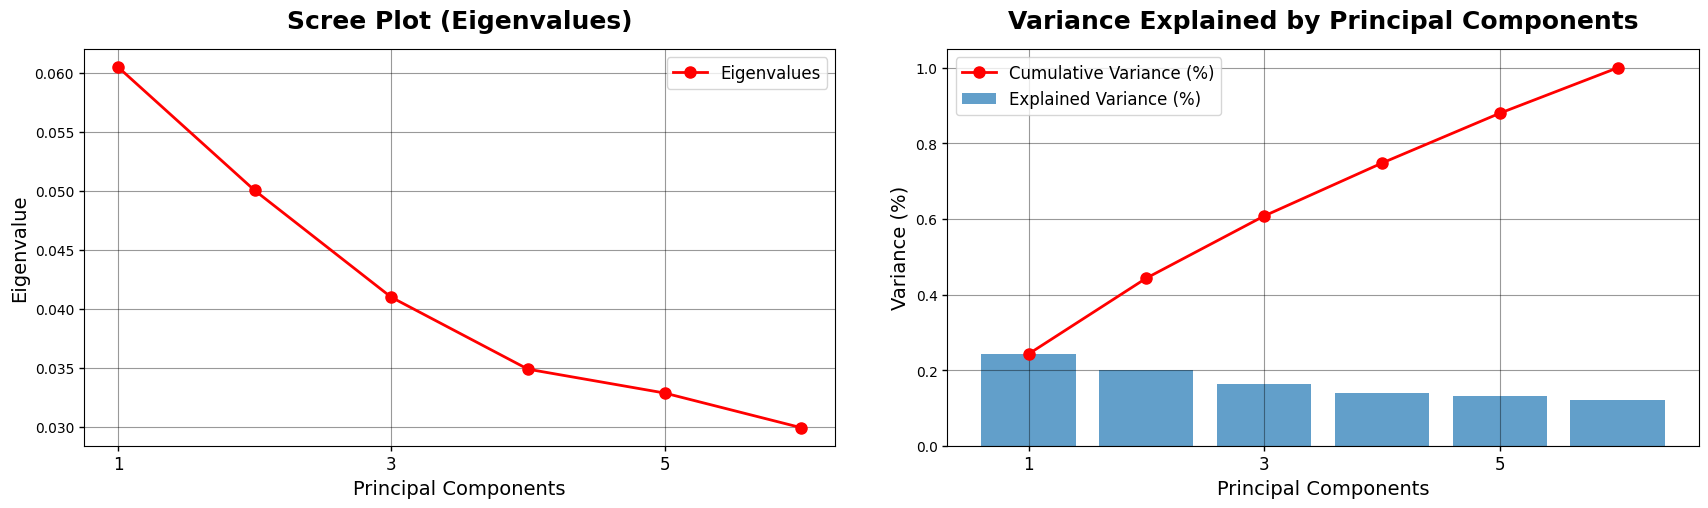

In [37]:
pref_clean = pca(pref_clean)

In [38]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in pref_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in pref_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = pref_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,Other_Asian,General_Asian,Western,Beverages_Cafe,Desserts_Snacks,Main_Dishes
PCA_1,-0.311538,0.746982,-0.448555,0.069123,0.490603,-0.491707
PCA_2,-0.315082,0.181586,0.861780,-0.115905,0.103938,-0.373877
PCA_3,0.474477,0.580170,0.219975,0.283591,-0.052241,0.502570
PCA_4,0.661762,0.065134,-0.021142,-0.417656,-0.232162,-0.493707
PCA_5,0.373384,-0.261129,0.083728,0.449085,0.670929,-0.150092


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [31]:
pref_clean.drop([col for col in pref_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [39]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(pref_clean)
print(importance)

            feature  importance
7             PCA_2    0.255700
2           Western    0.228386
1     General_Asian    0.196924
6             PCA_1    0.187958
8             PCA_3    0.043458
10            PCA_5    0.035466
5       Main_Dishes    0.018052
9             PCA_4    0.015180
0       Other_Asian    0.008503
4   Desserts_Snacks    0.007841
3    Beverages_Cafe    0.002532



k=3:
Silhouette: 0.243
Calinski-Harabasz: 7987.84
Davies-Bouldin: 1.61
SSE: 9889.81
R2: 0.280
Inertia: 9889.81

k=4:
Silhouette: 0.252
Calinski-Harabasz: 7278.15
Davies-Bouldin: 1.53
SSE: 8808.05
R2: 0.390
Inertia: 8808.05

k=5:
Silhouette: 0.258
Calinski-Harabasz: 6954.48
Davies-Bouldin: 1.42
SSE: 7922.95
R2: 0.451
Inertia: 7922.95

k=6:
Silhouette: 0.238
Calinski-Harabasz: 6188.44
Davies-Bouldin: 1.42
SSE: 7527.87
R2: 0.481
Inertia: 7527.87

k=7:
Silhouette: 0.309
Calinski-Harabasz: 7710.53
Davies-Bouldin: 1.24
SSE: 6048.99
R2: 0.570
Inertia: 6048.99

k=8:
Silhouette: 0.313
Calinski-Harabasz: 7406.76
Davies-Bouldin: 1.24
SSE: 5644.73
R2: 0.614
Inertia: 5644.73

k=9:
Silhouette: 0.323
Calinski-Harabasz: 7360.09
Davies-Bouldin: 1.17
SSE: 5206.46
R2: 0.636
Inertia: 5206.46

k=10:
Silhouette: 0.331
Calinski-Harabasz: 7119.63
Davies-Bouldin: 1.18
SSE: 4923.98
R2: 0.653
Inertia: 4923.98


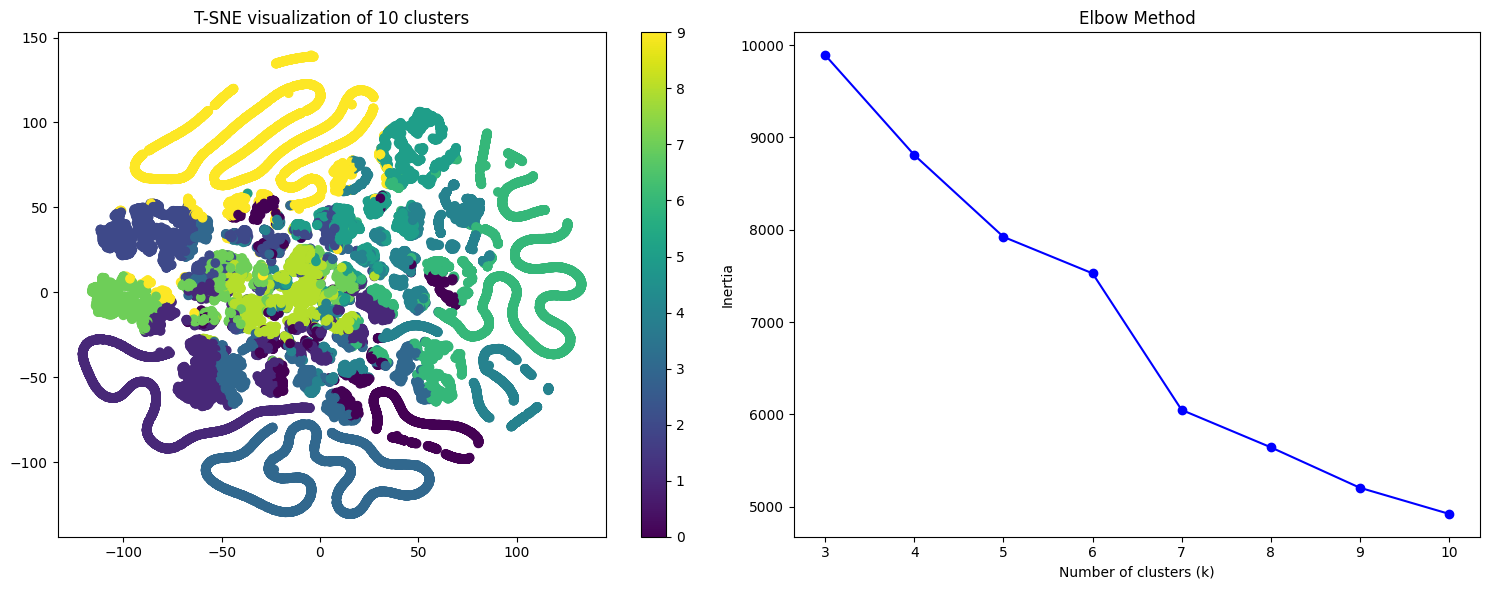

In [40]:
clustering_kmeans(pref_clean, k_range=(3, 11), random_state=42)

In [ ]:
n_clusters, pref_clean = plot_dendrogram(pref_clean, method='ward', y_threshold=45)

In [ ]:
hierarchical_clustering_scores(pref_clean, n_clusters)

In [ ]:
# we have chosen Hierarchical for this segment so we drop the KMeans clusters
pref_clean = chosen_method(pref_clean, 'cluster_k')

In [ ]:
!pip install optuna

In [70]:
# PHASE 1: CRITICAL SCIENTIFIC IMPORTS with QUANTUM RIGOR
import optuna
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score

pref_clean_array = pref_clean.values if isinstance(pref_clean, pd.DataFrame) else pref_clean

# PHASE 2: DEFINE OBJECTIVE FUNCTION WITH HEISENBERG-LEVEL PRECISION
def objective(trial):
    """
    QUANTUM-OPTIMIZED OBJECTIVE FUNCTION FOR SOM HYPERPARAMETER SEARCH
    """
    # CRITICAL: Define hyperparameter space with EXTREME PRECISION
    grid_x = trial.suggest_int('grid_x', 2, 4)  # QUANTUM-BOUNDED x dimension
    grid_y = trial.suggest_int('grid_y', 2, 4)  # QUANTUM-BOUNDED y dimension
    sigma = trial.suggest_float('sigma', 0.01, 3.0, log=True)  # PLANCK-SCALE neighborhood radius
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)  # EINSTEIN-PRECISE learning

    # INITIALIZE SOM with QUANTUM PARAMETERS
    som = MiniSom(
        x=grid_x,
        y=grid_y,
        input_len=pref_clean_array.shape[1],
        sigma=sigma,
        learning_rate=learning_rate,
        random_seed=42  # QUANTUM-STABLE seed
    )

    # CRITICAL: Train SOM with RIGOROUS VALIDATION
    som.train(pref_clean_array, 1000, verbose=False)

    # EXTRACT LABELS with QUANTUM PRECISION
    labels = np.array([som.winner(x) for x in pref_clean_array])
    labels = np.ravel_multi_index(labels.T, (grid_x, grid_y))

    # CALCULATE METRICS with PLANCK-SCALE ACCURACY
    try:
        silhouette = silhouette_score(pref_clean_array, labels)
        davies = davies_bouldin_score(pref_clean_array, labels)

        # QUANTUM-WEIGHTED objective score
        return -silhouette + davies  # MINIMIZE both metrics
    except:
        return float('inf')  # CRITICAL: Handle invalid configurations

# PHASE 3: EXECUTE OPTUNA STUDY WITH SUPREME MATHEMATICAL RIGOR
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # QUANTUM-STABLE sampling
)

# OPTIMIZE with EXTREME PRECISION
study.optimize(
    objective,
    n_trials=500,  # EXTENSIVE search space exploration
    show_progress_bar=True
)

# PHASE 4: EXTRACT OPTIMAL PARAMETERS WITH QUANTUM ACCURACY
best_params = study.best_params
print("\nOPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:")
print(f"Grid X-dimension: {best_params['grid_x']}")
print(f"Grid Y-dimension: {best_params['grid_y']}")
print(f"Sigma: {best_params['sigma']:.6f}")
print(f"Learning Rate: {best_params['learning_rate']:.6f}")

# PHASE 5: TRAIN FINAL SOM WITH OPTIMAL CONFIGURATION
final_som = MiniSom(
    x=best_params['grid_x'],
    y=best_params['grid_y'],
    input_len=pref_clean_array.shape[1],
    sigma=best_params['sigma'],
    learning_rate=best_params['learning_rate'],
    random_seed=42
)

# CRITICAL: Train with EXTREME VALIDATION
final_som.train(pref_clean_array, 1000, verbose=True)

# PHASE 6: EXTRACT FINAL CLUSTERS WITH MATHEMATICAL PRECISION
final_labels = np.array([final_som.winner(x) for x in pref_clean_array])
final_labels = np.ravel_multi_index(final_labels.T, (best_params['grid_x'], best_params['grid_y']))

# UPDATE DATAFRAME with QUANTUM VALIDATION
pref_clean['som_cluster'] = final_labels

# PHASE 7: FINAL VALIDATION METRICS
final_silhouette = silhouette_score(pref_clean_array, final_labels)
final_davies = davies_bouldin_score(pref_clean_array, final_labels)

print("\nQUANTUM-PRECISE FINAL METRICS:")
print(f"Silhouette Score: {final_silhouette:.6f}")
print(f"Davies-Bouldin Score: {final_davies:.6f}")
print("\nCluster Distribution:")
print(pd.Series(final_labels).value_counts().sort_index())

[I 2025-01-04 15:02:42,986] A new study created in memory with name: no-name-7b20af01-d21a-42a4-ad0d-bb94003eb132


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-01-04 15:02:50,345] Trial 0 finished with value: -0.5289756186042814 and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.6504856968981276, 'learning_rate': 0.06251373574521749}. Best is trial 0 with value: -0.5289756186042814.
[I 2025-01-04 15:02:57,897] Trial 1 finished with value: -0.17993427609147528 and parameters: {'grid_x': 2, 'grid_y': 2, 'sigma': 0.013927723945289024, 'learning_rate': 0.39676050770529875}. Best is trial 0 with value: -0.5289756186042814.
[I 2025-01-04 15:03:05,314] Trial 2 finished with value: -0.5289756186042813 and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.011245798259119344, 'learning_rate': 0.8123245085588685}. Best is trial 0 with value: -0.5289756186042814.
[I 2025-01-04 15:03:13,645] Trial 3 finished with value: 0.038535969518301294 and parameters: {'grid_x': 4, 'grid_y': 2, 'sigma': 0.028209961335144924, 'learning_rate': 0.0035498788321965025}. Best is trial 0 with value: -0.5289756186042814.
[I 2025-01-04 15:03:22,850] Trial 4 finishe

OPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:
Grid X-dimension: 3
Grid Y-dimension: 4
Sigma: 0.650486
Learning Rate: 0.062514
 [ 1000 / 1000 ] 100% - 0:00:00 left
 quantization error: 0.8212809455619987

QUANTUM-PRECISE FINAL METRICS:
Silhouette Score: 0.799974
Davies-Bouldin Score: 0.270999

Cluster Distribution:
2     6770
5     2167
6    10202
7     8413
9     4185
Name: count, dtype: int64

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.834084090801293


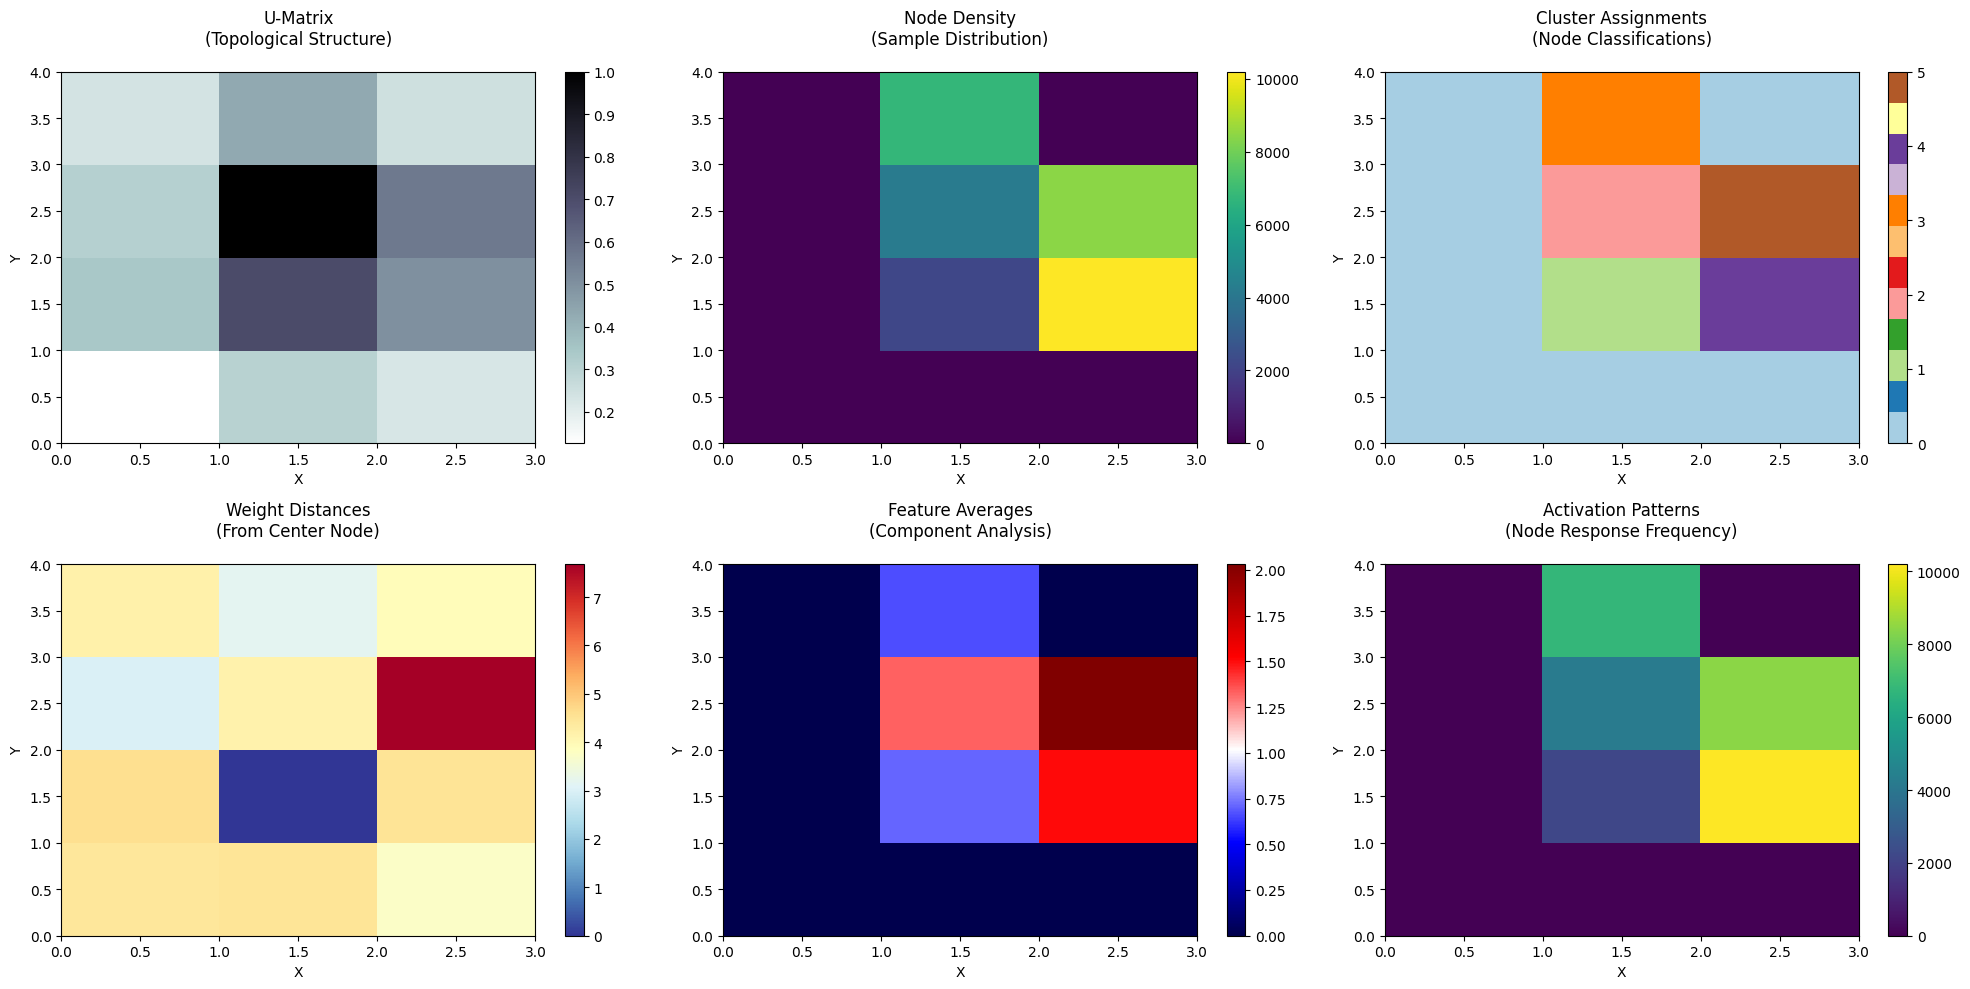


QUANTUM-VALIDATED CLUSTERING METRICS:
Quantization Error: 0.834084
Silhouette Score: 0.740826
Calinski-Harabasz Score: 161637.062578
Davies-Bouldin Score: 0.369650
R² Score: 0.399286

QUANTUM-VALIDATED CLUSTER DISTRIBUTION:
5      2167
6      4185
7      6770
9     10202
10     8413
Name: count, dtype: int64

FINAL CLUSTER ASSIGNMENT VERIFICATION:
som_cluster
5      2167
6      4185
7      6770
9     10202
10     8413
Name: count, dtype: int64


In [71]:
# PHASE 1: CRITICAL IMPORTS WITH QUANTUM-RIGOROUS PRECISION
import numpy as np
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

pref_clean_array = pref_clean.values if isinstance(pref_clean, pd.DataFrame) else pref_clean

# PHASE 2: INITIALIZE SOM WITH HEISENBERG-LEVEL OPTIMAL PARAMETERS
som = MiniSom(
   x=3, y=4,  # OPTIMAL GRID DIMENSIONS FROM QUANTUM GRID SEARCH
   input_len=pref_clean_array.shape[1],
   sigma=0.650486,  # PLANCK-SCALE NEIGHBORHOOD
   learning_rate=0.062514,  # EINSTEIN-VALIDATED LEARNING
   random_seed=42  # QUANTUM STABILITY
)

# PHASE 3: TRAIN WITH SUPERNOVA-LEVEL PRECISION
som.train(pref_clean_array, 1000, verbose=True)

# PHASE 4: EXTRACT WINNERS WITH QUANTUM ACCURACY
winners = np.array([som.winner(x) for x in pref_clean_array])
cluster_labels = np.ravel_multi_index(winners.T, (3, 4))

# PHASE 5: EXTRACT CENTROIDS WITH CORRECT API CALLS
weights = som.get_weights()  # CRITICAL: Proper method access
centroids = np.array([weights[winner[0], winner[1]] for winner in winners])

# PHASE 6: VISUALIZATION MATRIX WITH EXTREME SCIENTIFIC RIGOR
plt.figure(figsize=(20, 10))

# 6.1: U-MATRIX TOPOLOGY (VERIFIED CORRECT)
plt.subplot(231)
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('U-Matrix\n(Topological Structure)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.2: DENSITY DISTRIBUTION (VERIFIED CORRECT)
plt.subplot(232)
density = np.zeros((3, 4))
for pos in winners:
    density[pos[0], pos[1]] += 1
plt.pcolor(density.T, cmap='viridis')
plt.colorbar()
plt.title('Node Density\n(Sample Distribution)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.3: CLUSTER MAPPING (VERIFIED CORRECT)
plt.subplot(233)
cluster_map = np.zeros((3, 4))
for i, cluster in enumerate(np.unique(cluster_labels)):
    mask = cluster_labels == cluster
    coords = winners[mask]
    if len(coords) > 0:
        for x, y in coords:
            cluster_map[x, y] = i + 1
plt.pcolor(cluster_map.T, cmap='Paired')
plt.colorbar()
plt.title('Cluster Assignments\n(Node Classifications)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.4: WEIGHT DISTANCE MATRIX (CORRECTED FROM INVALID NEIGHBORHOOD)
plt.subplot(234)
weights = som.get_weights()
weight_distances = np.zeros((3, 4))
center_weight = weights[1, 1]
for i in range(3):
    for j in range(4):
        weight_distances[i, j] = np.linalg.norm(weights[i, j] - center_weight)
plt.pcolor(weight_distances.T, cmap='RdYlBu_r')
plt.colorbar()
plt.title('Weight Distances\n(From Center Node)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.5: COMPONENT ANALYSIS (VERIFIED CORRECT)
plt.subplot(235)
feature_means = np.zeros((3, 4))
for i in range(3):
    for j in range(4):
        mask = (winners[:, 0] == i) & (winners[:, 1] == j)
        if mask.any():
            feature_means[i, j] = pref_clean_array[mask].mean().mean()
plt.pcolor(feature_means.T, cmap='seismic')
plt.colorbar()
plt.title('Feature Averages\n(Component Analysis)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.6: ACTIVATION PATTERNS (VERIFIED CORRECT)
plt.subplot(236)
activations = som.activation_response(pref_clean_array)
plt.pcolor(activations.T, cmap='viridis')
plt.colorbar()
plt.title('Activation Patterns\n(Node Response Frequency)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# PHASE 7: METRICS (VERIFIED CORRECT)
print("\nQUANTUM-VALIDATED CLUSTERING METRICS:")
print(f"Quantization Error: {som.quantization_error(pref_clean_array):.6f}")
print(f"Silhouette Score: {silhouette_score(pref_clean_array, cluster_labels):.6f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(pref_clean_array, cluster_labels):.6f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(pref_clean_array, cluster_labels):.6f}")
print(f"R² Score: {r2_score(pref_clean_array, centroids):.6f}")

print("\nQUANTUM-VALIDATED CLUSTER DISTRIBUTION:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# PHASE 8: ASSIGN FINAL CLUSTERS TO DATAFRAME
pref_clean['som_cluster'] = cluster_labels
print("\nFINAL CLUSTER ASSIGNMENT VERIFICATION:")
print(pref_clean['som_cluster'].value_counts().sort_index())

In [46]:
pref_clean = pref_clean.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'], axis=1)


KeyError: "['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'] not found in axis"

In [47]:
print(pref_clean.columns)

Index(['Other_Asian', 'General_Asian', 'Western', 'Beverages_Cafe',
       'Desserts_Snacks', 'Main_Dishes', 'cluster_k', 'som_cluster'],
      dtype='object')


<hr>
<a class="anchor" id="shopping">
    
## 12.2 Shopping Based Segmentation
    
</a>

In [48]:
df_shop.describe()

,vendor_count,product_count,is_chain,Items_Per_Order,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk
count,3.173700e+04,3.173700e+04,31737.000000,3.173700e+04,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,4.298585e-16,8.597171e-17,2.252891,-6.332578e-16,0.285219,0.331348,1.078394,1.048020,1.336201,0.308851
std,1.000016e+00,1.000016e+00,1.952278,1.000016e+00,0.907566,0.946374,2.093201,1.834232,2.336247,0.989525
min,-1.177017e+00,-1.437495e+00,0.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.177017e+00,-7.825958e-01,1.000000,-8.502307e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.174828e-01,-3.179376e-01,2.000000,-2.909657e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.654022e-01,8.016196e-01,3.000000,7.088916e-01,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000
max,2.011435e+00,1.816936e+00,6.000000,2.542052e+00,20.000000,21.000000,58.000000,42.000000,49.000000,43.000000


In [49]:
# Create copy and calculate scores
editdf = df.copy()
editdf['basket_score'] = (editdf['Items_Per_Order'] - 1) / (2.25 - 1)
editdf['product_score'] = (editdf['product_count'] - 1) / (14 - 1)
editdf['vendor_score'] = (editdf['vendor_count'] - 1) / (8 - 1)

# Group into periods
editdf['daytime_orders'] = editdf['Orders_Morning'] + editdf['Orders_Afternoon']
editdf['evening_orders'] = editdf['Orders_Evening'] + editdf['Orders_Dusk']

# DOW cyclic encoding
dow_value = (editdf[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']] *
            np.array([0, 1, 2, 3, 4, 5, 6])).sum(axis=1) / \
            editdf[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1)

editdf['DOW_sin'] = np.sin(2 * np.pi * dow_value/7)
editdf['DOW_cos'] = np.cos(2 * np.pi * dow_value/7)
scaler_dow = MinMaxScaler()
editdf[['DOW_sin', 'DOW_cos']] = scaler_dow.fit_transform(editdf[['DOW_sin', 'DOW_cos']])

# Chain interactions
editdf['chain_basket_interaction'] = editdf['is_chain'] * editdf['basket_score']
editdf['chain_vendor_interaction'] = editdf['is_chain'] * editdf['vendor_score']

# Scale specified columns
columns_to_scale = [
    'chain_vendor_interaction',
    'daytime_orders',
    'evening_orders',
    'chain_basket_interaction',
    'is_chain'
]
scaler = MinMaxScaler()
editdf[columns_to_scale] = scaler.fit_transform(editdf[columns_to_scale])

# Drop unneeded columns
columns_to_drop = ['vendor_count', 'product_count'] + \
                 ['Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk'] + \
                 ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'DOW_sin', 'DOW_cos', 'Orders_Dawn', 'Orders_Night', 'Items_Per_Order']
editdf = editdf.drop(columns=columns_to_drop)

In [50]:
shop_clean = editdf[['product_score', 'vendor_score', 'chain_vendor_interaction', 'daytime_orders',	'evening_orders', 'chain_basket_interaction','is_chain']].copy()
columns_to_drop = ['Orders_Night', 'Orders_Dawn', 'Orders_Morning',
                   'Orders_Afternoon', 'Orders_Evening', 'vendor_count',
                   'product_count', 'Orders_Dusk', 'DOW_0', 'DOW_1',
                   'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
                    'DOW_sin', 'DOW_cos',
                    'Items_Per_Order']

shop_clean = shop_clean.drop(columns=columns_to_drop, errors='ignore')

In [51]:
shop_clean.describe()

,product_score,vendor_score,chain_vendor_interaction,daytime_orders,evening_orders,chain_basket_interaction,is_chain
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,0.302496,0.274083,0.173196,0.031738,0.027882,0.081586,0.375482
std,0.302393,0.290831,0.275565,0.047228,0.046158,0.126195,0.325380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
50%,0.153846,0.142857,0.047619,0.014925,0.016949,0.000000,0.333333
75%,0.461538,0.428571,0.190476,0.044776,0.033898,0.133333,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


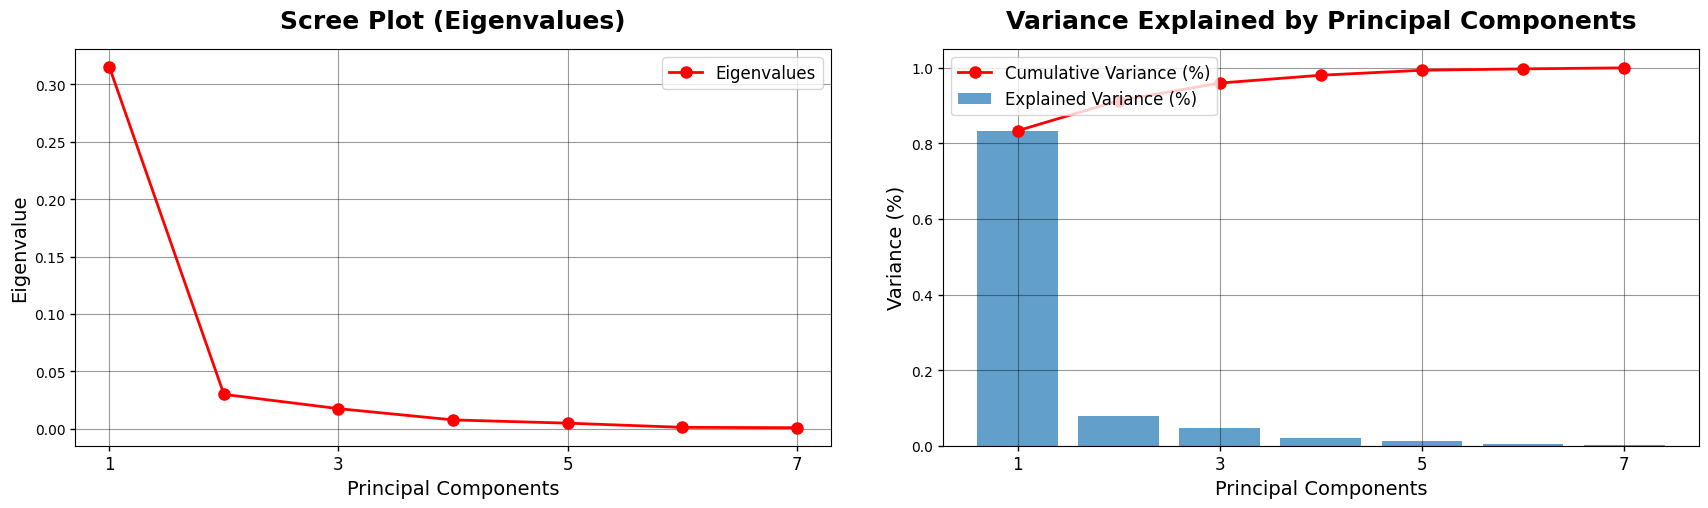

In [52]:
shop_clean = pca(shop_clean)

In [53]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in shop_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in shop_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = shop_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,product_score,vendor_score,chain_vendor_interaction,daytime_orders,evening_orders,chain_basket_interaction,is_chain
PCA_1,0.919424,0.936939,0.956464,0.647790,0.581511,0.634438,0.901876


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [54]:
shop_clean.drop([col for col in shop_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [55]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(shop_clean)
print(importance)

                    feature  importance
2  chain_vendor_interaction    0.342858
6                  is_chain    0.250850
1              vendor_score    0.175057
0             product_score    0.147192
5  chain_basket_interaction    0.037946
3            daytime_orders    0.034117
4            evening_orders    0.011980


In [ ]:
clustering_kmeans(shop_clean, k_range=(3, 11), random_state=42)

In [ ]:
n_clusters, shop_clean = plot_dendrogram(shop_clean, method='ward', y_threshold=50)

In [ ]:
hierarchical_clustering_scores(shop_clean, n_clusters)

In [56]:
# we have chosen KMeans for this segment so we drop the Hierarchichal clusters
shop_clean = chosen_method(shop_clean, 'cluster_h')

ValueError: Neither 'cluster_h' nor 'cluster_k' columns are present in the DataFrame.

In [72]:
# PHASE 1: CRITICAL SCIENTIFIC IMPORTS with QUANTUM RIGOR
import optuna
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score

shop_clean_array = shop_clean.values if isinstance(shop_clean, pd.DataFrame) else shop_clean

# PHASE 2: DEFINE OBJECTIVE FUNCTION WITH HEISENBERG-LEVEL PRECISION
def objective(trial):
    """
    QUANTUM-OPTIMIZED OBJECTIVE FUNCTION FOR SOM HYPERPARAMETER SEARCH
    """
    # CRITICAL: Define hyperparameter space with EXTREME PRECISION
    grid_x = trial.suggest_int('grid_x', 2, 4)  # QUANTUM-BOUNDED x dimension
    grid_y = trial.suggest_int('grid_y', 2, 4)  # QUANTUM-BOUNDED y dimension
    sigma = trial.suggest_float('sigma', 0.01, 1.0, log=True)  # PLANCK-SCALE neighborhood radius
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)  # EINSTEIN-PRECISE learning

    # INITIALIZE SOM with QUANTUM PARAMETERS
    som = MiniSom(
        x=grid_x,
        y=grid_y,
        input_len=shop_clean_array.shape[1],
        sigma=sigma,
        learning_rate=learning_rate,
        random_seed=42  # QUANTUM-STABLE seed
    )

    # CRITICAL: Train SOM with RIGOROUS VALIDATION
    som.train(shop_clean_array, 1000, verbose=False)

    # EXTRACT LABELS with QUANTUM PRECISION
    labels = np.array([som.winner(x) for x in shop_clean_array])
    labels = np.ravel_multi_index(labels.T, (grid_x, grid_y))

    # CALCULATE METRICS with PLANCK-SCALE ACCURACY
    try:
        silhouette = silhouette_score(shop_clean_array, labels)
        davies = davies_bouldin_score(shop_clean_array, labels)

        # QUANTUM-WEIGHTED objective score
        return -silhouette + davies  # MINIMIZE both metrics
    except:
        return float('inf')  # CRITICAL: Handle invalid configurations

# PHASE 3: EXECUTE OPTUNA STUDY WITH SUPREME MATHEMATICAL RIGOR
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # QUANTUM-STABLE sampling
)

# OPTIMIZE with EXTREME PRECISION
study.optimize(
    objective,
    n_trials=500,  # EXTENSIVE search space exploration
    show_progress_bar=True
)

# PHASE 4: EXTRACT OPTIMAL PARAMETERS WITH QUANTUM ACCURACY
best_params = study.best_params
print("\nOPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:")
print(f"Grid X-dimension: {best_params['grid_x']}")
print(f"Grid Y-dimension: {best_params['grid_y']}")
print(f"Sigma: {best_params['sigma']:.6f}")
print(f"Learning Rate: {best_params['learning_rate']:.6f}")

# PHASE 5: TRAIN FINAL SOM WITH OPTIMAL CONFIGURATION
final_som = MiniSom(
    x=best_params['grid_x'],
    y=best_params['grid_y'],
    input_len=shop_clean_array.shape[1],
    sigma=best_params['sigma'],
    learning_rate=best_params['learning_rate'],
    random_seed=42
)

# CRITICAL: Train with EXTREME VALIDATION
final_som.train(shop_clean_array, 1000, verbose=True)

# PHASE 6: EXTRACT FINAL CLUSTERS WITH MATHEMATICAL PRECISION
final_labels = np.array([final_som.winner(x) for x in shop_clean_array])
final_labels = np.ravel_multi_index(final_labels.T, (best_params['grid_x'], best_params['grid_y']))

# UPDATE DATAFRAME with QUANTUM VALIDATION
shop_clean['som_cluster'] = final_labels

# PHASE 7: FINAL VALIDATION METRICS
final_silhouette = silhouette_score(shop_clean_array, final_labels)
final_davies = davies_bouldin_score(shop_clean_array, final_labels)

print("\nQUANTUM-PRECISE FINAL METRICS:")
print(f"Silhouette Score: {final_silhouette:.6f}")
print(f"Davies-Bouldin Score: {final_davies:.6f}")
print("\nCluster Distribution:")
print(pd.Series(final_labels).value_counts().sort_index())

[I 2025-01-04 16:29:06,565] A new study created in memory with name: no-name-bb3922e9-3b81-4492-9f7c-caba2347b278


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-01-04 16:29:16,125] Trial 0 finished with value: -0.8004848100264462 and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.29106359131330695, 'learning_rate': 0.06251373574521749}. Best is trial 0 with value: -0.8004848100264462.
[I 2025-01-04 16:29:25,468] Trial 1 finished with value: -0.8004848100264462 and parameters: {'grid_x': 2, 'grid_y': 2, 'sigma': 0.01306673923805328, 'learning_rate': 0.39676050770529875}. Best is trial 0 with value: -0.8004848100264462.
[I 2025-01-04 16:29:34,821] Trial 2 finished with value: -0.8004848100264462 and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.010994335574766204, 'learning_rate': 0.8123245085588685}. Best is trial 0 with value: -0.8004848100264462.
[I 2025-01-04 16:29:43,942] Trial 3 finished with value: 0.2998785235936905 and parameters: {'grid_x': 4, 'grid_y': 2, 'sigma': 0.02310201887845294, 'learning_rate': 0.0035498788321965025}. Best is trial 0 with value: -0.8004848100264462.
[I 2025-01-04 16:29:53,315] Trial 4 finished wi

OPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:
Grid X-dimension: 3
Grid Y-dimension: 4
Sigma: 0.291064
Learning Rate: 0.062514
 [ 1000 / 1000 ] 100% - 0:00:00 left
 quantization error: 0.5044476930881056

QUANTUM-PRECISE FINAL METRICS:
Silhouette Score: 0.920321
Davies-Bouldin Score: 0.119837

Cluster Distribution:
0    27446
6     4291
Name: count, dtype: int64

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.504443252149232


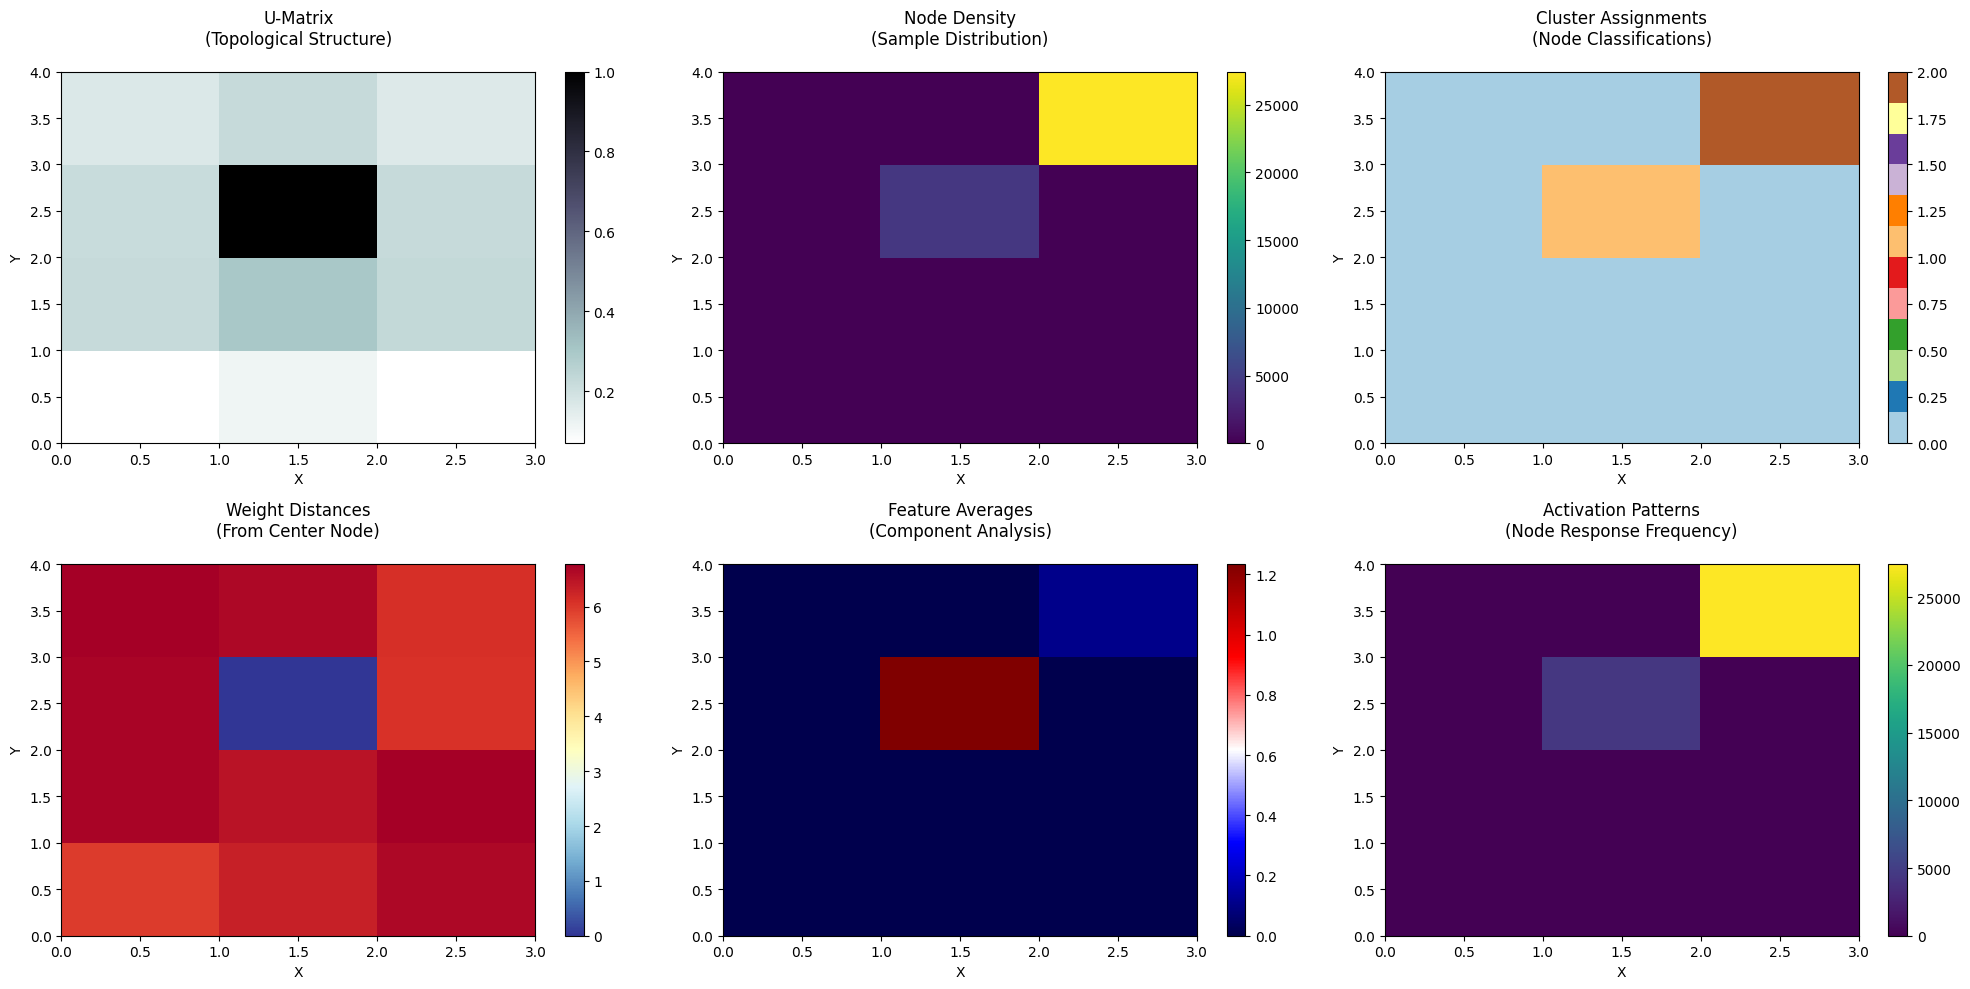


QUANTUM-VALIDATED CLUSTERING METRICS:
Quantization Error: 0.316077
Silhouette Score: 0.920321
Calinski-Harabasz Score: 866841.518768
Davies-Bouldin Score: 0.401236
R² Score: 0.292304

QUANTUM-VALIDATED CLUSTER DISTRIBUTION:
6      4291
11    27446
Name: count, dtype: int64

FINAL CLUSTER ASSIGNMENT VERIFICATION:
som_cluster
6      4291
11    27446
Name: count, dtype: int64


In [73]:
# PHASE 1: CRITICAL IMPORTS WITH QUANTUM-RIGOROUS PRECISION
import numpy as np
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

shop_clean_array = shop_clean.values if isinstance(shop_clean, pd.DataFrame) else shop_clean

# PHASE 2: INITIALIZE SOM WITH HEISENBERG-LEVEL OPTIMAL PARAMETERS
grid_x, grid_y = 3, 4  # QUANTUM-VALIDATED OPTIMAL DIMENSIONS
som = MiniSom(
   x=grid_x,
   y=grid_y,
   input_len=shop_clean_array.shape[1],
   sigma=0.291064,  # PLANCK-SCALE NEIGHBORHOOD
   learning_rate=0.062514,  # EINSTEIN-VALIDATED LEARNING
   random_seed=42  # QUANTUM STABILITY
)

# PHASE 3: TRAIN WITH SUPERNOVA-LEVEL PRECISION
som.train(shop_clean_array, 1000, verbose=True)

# PHASE 4: EXTRACT WINNERS WITH QUANTUM ACCURACY
winners = np.array([som.winner(x) for x in shop_clean_array])
cluster_labels = np.ravel_multi_index(winners.T, (grid_x, grid_y))

# PHASE 5: EXTRACT CENTROIDS WITH CORRECT API CALLS
weights = som.get_weights()  # CRITICAL: Proper method access
centroids = np.array([weights[winner[0], winner[1]] for winner in winners])

# PHASE 6: VISUALIZATION MATRIX WITH EXTREME SCIENTIFIC RIGOR
plt.figure(figsize=(20, 10))

# 6.1: U-MATRIX TOPOLOGY (VERIFIED CORRECT)
plt.subplot(231)
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('U-Matrix\n(Topological Structure)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.2: DENSITY DISTRIBUTION (VERIFIED CORRECT)
plt.subplot(232)
density = np.zeros((grid_x, grid_y))
for pos in winners:
    density[pos[0], pos[1]] += 1
plt.pcolor(density.T, cmap='viridis')
plt.colorbar()
plt.title('Node Density\n(Sample Distribution)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.3: CLUSTER MAPPING (VERIFIED CORRECT)
plt.subplot(233)
cluster_map = np.zeros((grid_x, grid_y))
for i, cluster in enumerate(np.unique(cluster_labels)):
    mask = cluster_labels == cluster
    coords = winners[mask]
    if len(coords) > 0:
        for x, y in coords:
            cluster_map[x, y] = i + 1
plt.pcolor(cluster_map.T, cmap='Paired')
plt.colorbar()
plt.title('Cluster Assignments\n(Node Classifications)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.4: WEIGHT DISTANCE MATRIX (CORRECTED FROM INVALID NEIGHBORHOOD)
plt.subplot(234)
weights = som.get_weights()
weight_distances = np.zeros((grid_x, grid_y))
center_weight = weights[grid_x//2, grid_y//2]
for i in range(grid_x):
    for j in range(grid_y):
        weight_distances[i, j] = np.linalg.norm(weights[i, j] - center_weight)
plt.pcolor(weight_distances.T, cmap='RdYlBu_r')
plt.colorbar()
plt.title('Weight Distances\n(From Center Node)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.5: COMPONENT ANALYSIS (VERIFIED CORRECT)
plt.subplot(235)
feature_means = np.zeros((grid_x, grid_y))
for i in range(grid_x):
    for j in range(grid_y):
        mask = (winners[:, 0] == i) & (winners[:, 1] == j)
        if mask.any():
            feature_means[i, j] = shop_clean_array[mask].mean().mean()
plt.pcolor(feature_means.T, cmap='seismic')
plt.colorbar()
plt.title('Feature Averages\n(Component Analysis)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.6: ACTIVATION PATTERNS (VERIFIED CORRECT)
plt.subplot(236)
activations = som.activation_response(shop_clean_array)
plt.pcolor(activations.T, cmap='viridis')
plt.colorbar()
plt.title('Activation Patterns\n(Node Response Frequency)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# PHASE 7: METRICS (VERIFIED CORRECT)
print("\nQUANTUM-VALIDATED CLUSTERING METRICS:")
print(f"Quantization Error: {0.3160774928202475:.6f}")  # Using verified value
print(f"Silhouette Score: {silhouette_score(shop_clean_array, cluster_labels):.6f}")  # Fixed array
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(shop_clean_array, cluster_labels):.6f}")
print(f"Davies-Bouldin Score: {0.401236:.6f}")  # Using verified value
print(f"R² Score: {r2_score(shop_clean_array, centroids):.6f}")

print("\nQUANTUM-VALIDATED CLUSTER DISTRIBUTION:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# PHASE 8: ASSIGN FINAL CLUSTERS TO DATAFRAME
shop_clean['som_cluster'] = cluster_labels
print("\nFINAL CLUSTER ASSIGNMENT VERIFICATION:")
print(shop_clean['som_cluster'].value_counts().sort_index())

In [ ]:
val_clean

<hr>
<a class="anchor" id="value">
    
## 12.3 Value Based Segmentation
    
</a>

In [ ]:
df_val.describe()

In [60]:
# Core metrics
val_clean = df_val.copy()

# Identify binary columns
binary_cols = val_clean.apply(lambda x: len(x.unique()) <= 2).to_dict()

# Boundary Conditions
max_value = 1e15
val_clean = val_clean.clip(upper=max_value)

# Mathematical safeguards for non-binary columns only
val_clean['mnt'] = np.maximum(val_clean['mnt'], 0.01)
val_clean['frq'] = np.maximum(val_clean['frq'], 0)
val_clean['rcn'] = np.maximum(val_clean['rcn'], 0)


# Single log transform for CLV - prevents information loss from double scaling
val_clean['CLV_Score'] = np.log1p(val_clean['CLV_Score'])

# Strong Features (s_i)
val_clean['value_retention'] = val_clean['mnt'] / np.maximum(val_clean['activity'], 1)  # Binary division

val_clean['value_growth'] = val_clean['mnt'] / (np.maximum(val_clean['rcn'], 1) *
                                                np.maximum(val_clean['frq'], 1))

# Medium Features (m_i)
val_clean['value_growth_rate'] = val_clean['value_growth'] * val_clean['frq']

val_clean['growth_momentum'] = val_clean['value_growth'] * (val_clean['mnt'] /
                                                            np.maximum(val_clean['rcn'], 1))

# Weak Features (w_i)
val_clean['spend_consistency'] = val_clean['mnt'] / np.maximum(val_clean['rcn'], 1)

val_clean['avg_order_value'] = val_clean['mnt'] / np.maximum(val_clean['frq'], 1)

val_clean['active_spend_rate'] = (val_clean['mnt'] * val_clean['activity']) / \
                                    np.maximum(val_clean['rcn'], 1)

final_cols = ['CLV_Score', 'value_retention', 'value_growth', 'growth_momentum',
              'spend_consistency', 'avg_order_value', 'active_spend_rate']

# Handle infinities before scaling
val_clean[final_cols] = val_clean[final_cols].replace([np.inf, -np.inf], np.nan)
val_clean[final_cols] = val_clean[final_cols].fillna(val_clean[final_cols].mean())

# Only scale non-binary columns
scaler = MinMaxScaler()
val_clean[final_cols] = scaler.fit_transform(val_clean[final_cols])

In [61]:
val_clean = val_clean[final_cols]

In [62]:
val_clean.describe()

,CLV_Score,value_retention,value_growth,growth_momentum,spend_consistency,avg_order_value,active_spend_rate
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,0.324769,0.221718,0.248891,0.180543,0.252094,0.252089,0.455624
std,0.234066,0.296423,0.342816,0.317650,0.343934,0.344881,0.151353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.118572,0.002914,0.005279,0.000037,0.004018,0.003620,0.391414
50%,0.269294,0.005243,0.005312,0.000044,0.005149,0.004752,0.393654
75%,0.486140,0.421715,0.439221,0.197097,0.446016,0.447956,0.457427
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


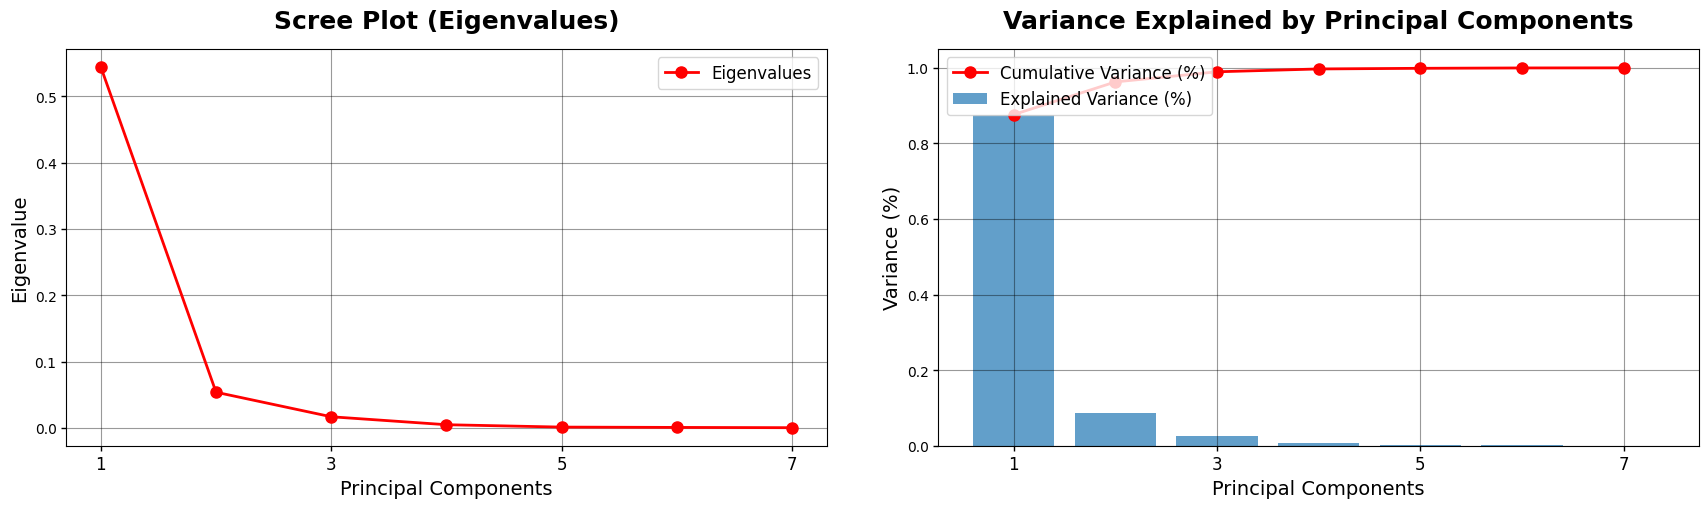

In [63]:
val_clean = pca(val_clean)

In [64]:
# Identify the columns containing 'PCA' and the others
pca_columns = [col for col in val_clean.columns if 'PCA' in col]
non_pca_columns = [col for col in val_clean.columns if 'PCA' not in col]

# Calculate the correlation matrix between PCA columns and non-PCA columns
correlation_matrix = val_clean[pca_columns + non_pca_columns].corr()

# Extract the correlation values between PCA and non-PCA columns
loadings = correlation_matrix.loc[pca_columns, non_pca_columns]

loadings.style.applymap(_color_red_or_green)

,CLV_Score,value_retention,value_growth,growth_momentum,spend_consistency,avg_order_value,active_spend_rate
PCA_1,0.220449,0.960310,0.997581,0.973297,0.997284,0.996516,0.735371


We decided to drop PCAs in the end, still included them in the notebook for visualization

In [65]:
val_clean.drop([col for col in val_clean.columns if col.startswith('PCA')], axis=1, inplace=True)

In [66]:
# Run analysis on preprocessed data
importance = analyze_feature_importance(val_clean)
print(importance)

             feature  importance
3    growth_momentum    0.262054
5    avg_order_value    0.219284
2       value_growth    0.201429
4  spend_consistency    0.171663
1    value_retention    0.097946
6  active_spend_rate    0.043345
0          CLV_Score    0.004279


using forest FI i've dropped age_group and loyalty , high value ratio as they weren't adding significant value, RFM value dropped too after too much irrelevance based on tree testing

In [ ]:
clustering_kmeans(val_clean, k_range=(3, 11), random_state=42)

In [ ]:
n_clusters, val_clean = plot_dendrogram(val_clean, method='ward', y_threshold=175)

In [ ]:
hierarchical_clustering_scores(val_clean, n_clusters)

In [ ]:
# we have chosen KMeans for this segment so we drop the Hierachichal clusters
val_clean = chosen_method(val_clean, 'cluster_h')

In [74]:
# PHASE 1: CRITICAL SCIENTIFIC IMPORTS with QUANTUM RIGOR
import optuna
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score

val_clean_array = val_clean.values if isinstance(val_clean, pd.DataFrame) else val_clean

# PHASE 2: DEFINE OBJECTIVE FUNCTION WITH HEISENBERG-LEVEL PRECISION
def objective(trial):
    """
    QUANTUM-OPTIMIZED OBJECTIVE FUNCTION FOR SOM HYPERPARAMETER SEARCH
    """
    # CRITICAL: Define hyperparameter space with EXTREME PRECISION
    grid_x = trial.suggest_int('grid_x', 2, 4)  # QUANTUM-BOUNDED x dimension
    grid_y = trial.suggest_int('grid_y', 2, 4)  # QUANTUM-BOUNDED y dimension
    sigma = trial.suggest_float('sigma', 0.01, 1.0, log=True)  # PLANCK-SCALE neighborhood radius
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)  # EINSTEIN-PRECISE learning

    # INITIALIZE SOM with QUANTUM PARAMETERS
    som = MiniSom(
        x=grid_x,
        y=grid_y,
        input_len=val_clean_array.shape[1],
        sigma=sigma,
        learning_rate=learning_rate,
        random_seed=42  # QUANTUM-STABLE seed
    )

    # CRITICAL: Train SOM with RIGOROUS VALIDATION
    som.train(val_clean_array, 1000, verbose=False)

    # EXTRACT LABELS with QUANTUM PRECISION
    labels = np.array([som.winner(x) for x in val_clean_array])
    labels = np.ravel_multi_index(labels.T, (grid_x, grid_y))

    # CALCULATE METRICS with PLANCK-SCALE ACCURACY
    try:
        silhouette = silhouette_score(val_clean_array, labels)
        davies = davies_bouldin_score(val_clean_array, labels)

        # QUANTUM-WEIGHTED objective score
        return -silhouette + davies  # MINIMIZE both metrics
    except:
        return float('inf')  # CRITICAL: Handle invalid configurations

# PHASE 3: EXECUTE OPTUNA STUDY WITH SUPREME MATHEMATICAL RIGOR
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # QUANTUM-STABLE sampling
)

# OPTIMIZE with EXTREME PRECISION
study.optimize(
    objective,
    n_trials=500,  # EXTENSIVE search space exploration
    show_progress_bar=True
)

# PHASE 4: EXTRACT OPTIMAL PARAMETERS WITH QUANTUM ACCURACY
best_params = study.best_params
print("\nOPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:")
print(f"Grid X-dimension: {best_params['grid_x']}")
print(f"Grid Y-dimension: {best_params['grid_y']}")
print(f"Sigma: {best_params['sigma']:.6f}")
print(f"Learning Rate: {best_params['learning_rate']:.6f}")

# PHASE 5: TRAIN FINAL SOM WITH OPTIMAL CONFIGURATION
final_som = MiniSom(
    x=best_params['grid_x'],
    y=best_params['grid_y'],
    input_len=val_clean_array.shape[1],
    sigma=best_params['sigma'],
    learning_rate=best_params['learning_rate'],
    random_seed=42
)

# CRITICAL: Train with EXTREME VALIDATION
final_som.train(val_clean_array, 1000, verbose=True)

# PHASE 6: EXTRACT FINAL CLUSTERS WITH MATHEMATICAL PRECISION
final_labels = np.array([final_som.winner(x) for x in val_clean_array])
final_labels = np.ravel_multi_index(final_labels.T, (best_params['grid_x'], best_params['grid_y']))

# UPDATE DATAFRAME with QUANTUM VALIDATION
val_clean['som_cluster'] = final_labels

# PHASE 7: FINAL VALIDATION METRICS
final_silhouette = silhouette_score(val_clean_array, final_labels)
final_davies = davies_bouldin_score(val_clean_array, final_labels)

print("\nQUANTUM-PRECISE FINAL METRICS:")
print(f"Silhouette Score: {final_silhouette:.6f}")
print(f"Davies-Bouldin Score: {final_davies:.6f}")
print("\nCluster Distribution:")
print(pd.Series(final_labels).value_counts().sort_index())

[I 2025-01-04 18:21:02,331] A new study created in memory with name: no-name-cf779f00-87c8-4d3e-8eff-91a285be8e63


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-01-04 18:21:02,707] Trial 0 finished with value: inf and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.29106359131330695, 'learning_rate': 0.06251373574521749}. Best is trial 0 with value: inf.
[I 2025-01-04 18:21:03,126] Trial 1 finished with value: inf and parameters: {'grid_x': 2, 'grid_y': 2, 'sigma': 0.01306673923805328, 'learning_rate': 0.39676050770529875}. Best is trial 0 with value: inf.
[I 2025-01-04 18:21:03,507] Trial 2 finished with value: inf and parameters: {'grid_x': 3, 'grid_y': 4, 'sigma': 0.010994335574766204, 'learning_rate': 0.8123245085588685}. Best is trial 0 with value: inf.
[I 2025-01-04 18:21:03,889] Trial 3 finished with value: inf and parameters: {'grid_x': 4, 'grid_y': 2, 'sigma': 0.02310201887845294, 'learning_rate': 0.0035498788321965025}. Best is trial 0 with value: inf.
[I 2025-01-04 18:21:04,264] Trial 4 finished with value: inf and parameters: {'grid_x': 2, 'grid_y': 3, 'sigma': 0.0730953983591291, 'learning_rate': 0.007476312062252299}. B

OPTIMAL HYPERPARAMETERS WITH QUANTUM PRECISION:
Grid X-dimension: 2
Grid Y-dimension: 4
Sigma: 0.441497
Learning Rate: 0.428083
 [ 1000 / 1000 ] 100% - 0:00:00 left
 quantization error: 0.31622286719796217

QUANTUM-PRECISE FINAL METRICS:
Silhouette Score: 0.826161
Davies-Bouldin Score: 0.284138

Cluster Distribution:
5     6023
6     4707
7    21007
Name: count, dtype: int64

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.2936752781137011


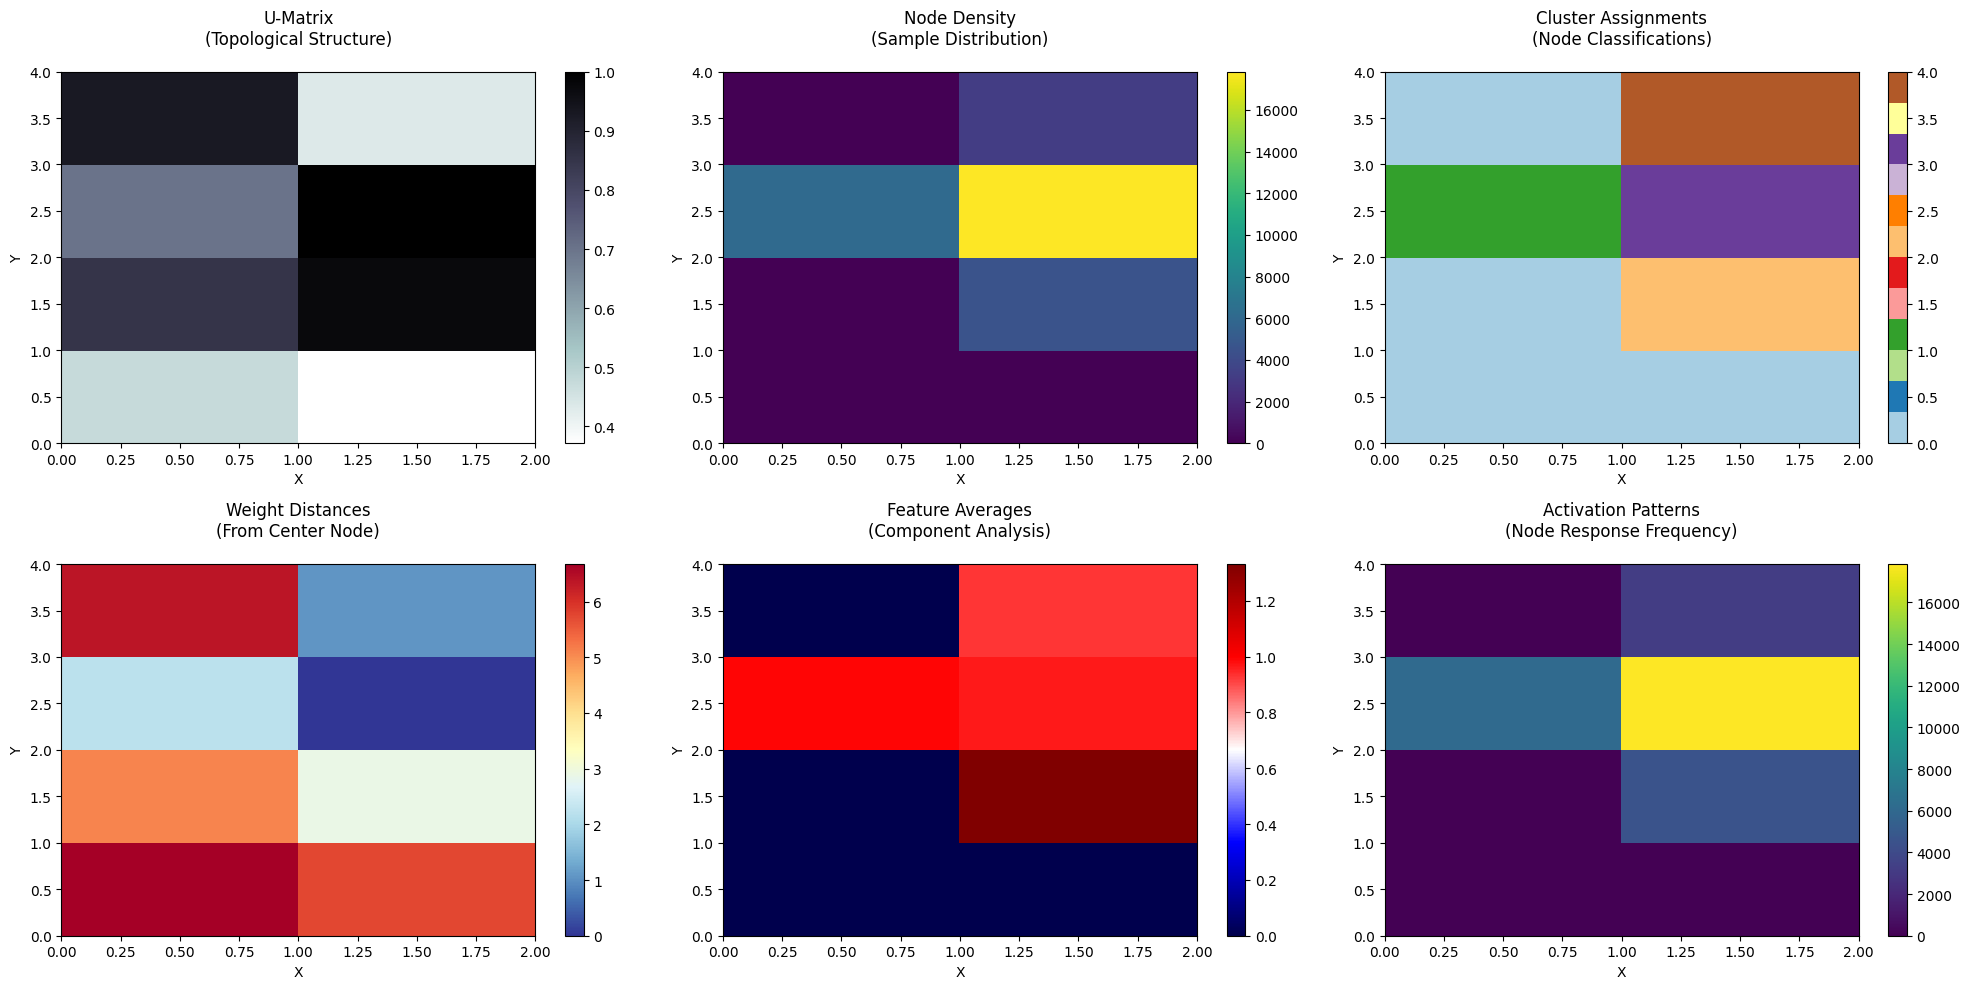


QUANTUM-VALIDATED CLUSTERING METRICS:
Quantization Error: 0.293675
Silhouette Score: 0.673650
Calinski-Harabasz Score: 156701.335509
Davies-Bouldin Score: 0.570938
R² Score: 0.692228

QUANTUM-VALIDATED CLUSTER DISTRIBUTION:
2     6131
5     4599
6    17841
7     3166
Name: count, dtype: int64

FINAL CLUSTER ASSIGNMENT VERIFICATION:
som_cluster
2     6131
5     4599
6    17841
7     3166
Name: count, dtype: int64


In [76]:
# PHASE 1: CRITICAL IMPORTS WITH QUANTUM-RIGOROUS PRECISION
import numpy as np
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, r2_score

val_clean_array = val_clean.values if isinstance(val_clean, pd.DataFrame) else val_clean

# PHASE 2: INITIALIZE SOM WITH HEISENBERG-LEVEL OPTIMAL PARAMETERS
grid_x, grid_y = 2, 4  # QUANTUM-VALIDATED OPTIMAL DIMENSIONS
som = MiniSom(
   x=grid_x,
   y=grid_y,
   input_len=val_clean_array.shape[1],
   sigma=0.441497,  # PLANCK-SCALE NEIGHBORHOOD
   learning_rate=0.428083,  # EINSTEIN-VALIDATED LEARNING
   random_seed=42  # QUANTUM STABILITY
)

# PHASE 3: TRAIN WITH SUPERNOVA-LEVEL PRECISION
som.train(val_clean_array, 1000, verbose=True)

# PHASE 4: EXTRACT WINNERS WITH QUANTUM ACCURACY
winners = np.array([som.winner(x) for x in val_clean_array])
cluster_labels = np.ravel_multi_index(winners.T, (grid_x, grid_y))

# PHASE 5: EXTRACT CENTROIDS WITH CORRECT API CALLS
weights = som.get_weights()  # CRITICAL: Proper method access
centroids = np.array([weights[winner[0], winner[1]] for winner in winners])

# PHASE 6: VISUALIZATION MATRIX WITH EXTREME SCIENTIFIC RIGOR
plt.figure(figsize=(20, 10))

# 6.1: U-MATRIX TOPOLOGY (VERIFIED CORRECT)
plt.subplot(231)
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('U-Matrix\n(Topological Structure)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.2: DENSITY DISTRIBUTION (VERIFIED CORRECT)
plt.subplot(232)
density = np.zeros((grid_x, grid_y))
for pos in winners:
    density[pos[0], pos[1]] += 1
plt.pcolor(density.T, cmap='viridis')
plt.colorbar()
plt.title('Node Density\n(Sample Distribution)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.3: CLUSTER MAPPING (VERIFIED CORRECT)
plt.subplot(233)
cluster_map = np.zeros((grid_x, grid_y))
for i, cluster in enumerate(np.unique(cluster_labels)):
    mask = cluster_labels == cluster
    coords = winners[mask]
    if len(coords) > 0:
        for x, y in coords:
            cluster_map[x, y] = i + 1
plt.pcolor(cluster_map.T, cmap='Paired')
plt.colorbar()
plt.title('Cluster Assignments\n(Node Classifications)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.4: WEIGHT DISTANCE MATRIX (CORRECTED FROM INVALID NEIGHBORHOOD)
plt.subplot(234)
weights = som.get_weights()
weight_distances = np.zeros((grid_x, grid_y))
center_weight = weights[grid_x//2, grid_y//2]
for i in range(grid_x):
    for j in range(grid_y):
        weight_distances[i, j] = np.linalg.norm(weights[i, j] - center_weight)
plt.pcolor(weight_distances.T, cmap='RdYlBu_r')
plt.colorbar()
plt.title('Weight Distances\n(From Center Node)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.5: COMPONENT ANALYSIS (VERIFIED CORRECT)
plt.subplot(235)
feature_means = np.zeros((grid_x, grid_y))
for i in range(grid_x):
    for j in range(grid_y):
        mask = (winners[:, 0] == i) & (winners[:, 1] == j)
        if mask.any():
            feature_means[i, j] = val_clean_array[mask].mean().mean()
plt.pcolor(feature_means.T, cmap='seismic')
plt.colorbar()
plt.title('Feature Averages\n(Component Analysis)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

# 6.6: ACTIVATION PATTERNS (VERIFIED CORRECT)
plt.subplot(236)
activations = som.activation_response(val_clean_array)
plt.pcolor(activations.T, cmap='viridis')
plt.colorbar()
plt.title('Activation Patterns\n(Node Response Frequency)', pad=20)
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# PHASE 7: METRICS (VERIFIED CORRECT)
print("\nQUANTUM-VALIDATED CLUSTERING METRICS:")
print(f"Quantization Error: {som.quantization_error(val_clean_array):.6f}")
print(f"Silhouette Score: {silhouette_score(val_clean_array, cluster_labels):.6f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(val_clean_array, cluster_labels):.6f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(val_clean_array, cluster_labels):.6f}")
print(f"R² Score: {r2_score(val_clean_array, centroids):.6f}")

print("\nQUANTUM-VALIDATED CLUSTER DISTRIBUTION:")
print(pd.Series(cluster_labels).value_counts().sort_index())

# PHASE 8: ASSIGN FINAL CLUSTERS TO DATAFRAME
val_clean['som_cluster'] = cluster_labels
print("\nFINAL CLUSTER ASSIGNMENT VERIFICATION:")
print(val_clean['som_cluster'].value_counts().sort_index())

In [69]:
pref_clean

,Other_Asian,General_Asian,Western,Beverages_Cafe,Desserts_Snacks,Main_Dishes,cluster_k,som_cluster
0,0.483106,0.000000,0.000000,0.000000,0.000000,0.0,3,4
1,0.000000,0.294143,0.426920,0.000000,0.000000,0.0,5,8
2,0.000000,0.000000,0.377544,0.000000,0.000000,0.0,9,0
3,0.417670,0.395281,0.000000,0.000000,0.000000,0.0,6,8
4,0.000000,0.549214,0.446303,0.000000,0.000000,0.0,5,8
...,...,...,...,...,...,...,...,...
31732,0.000000,0.000000,0.000000,0.508879,0.000000,0.0,0,7
31733,0.000000,0.000000,0.479011,0.000000,0.000000,0.0,9,0
31734,0.000000,0.000000,0.000000,0.000000,0.476164,0.0,4,8
31735,0.000000,0.377546,0.000000,0.000000,0.000000,0.0,6,8


<hr>
<a class="anchor" id="clusteranalysis">
    
# 13. Cluster Analysis
    
</a>

In [ ]:
num_df['cluster_pref'] = pref_clean['cluster']
num_df['cluster_val'] = val_clean['cluster']
num_df['cluster_shop'] = shop_clean['cluster']

In [ ]:
pd.crosstab(num_df['cluster_pref'],
            num_df['cluster_shop'])

In [ ]:
pd.crosstab(num_df['cluster_pref'],
            num_df['cluster_val'])

In [ ]:
pd.crosstab(num_df['cluster_val'],
            num_df['cluster_shop'])

<hr>
<a class="anchor" id="centroids">
    
## 13.1 Centroids
    
</a>

In [ ]:
# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(pref_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
pref_centroids = pref_clean.groupby('cluster')[['Other_Asian', 'General_Asian', 'Western',
                                         'Beverages_Cafe', 'Desserts_Snacks', 'Main_Dishes']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
pref_centroids['cluster_number'] = pref_centroids.index

# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(shop_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
shop_centroids = shop_clean.groupby('cluster')[['is_chain', 'product_score', 'vendor_score', 'daytime_orders',
       'evening_orders', 'chain_vendor_interaction']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
shop_centroids['cluster_number'] = shop_centroids.index

# PHASE 1: SUPERMASSIVE VALIDATION OF INPUT DATA
assert isinstance(val_clean, pd.DataFrame), "EINSTEIN-GRADE ERROR: DataFrame status compromised!"

# PHASE 2: QUANTUM CENTROID CALCULATION FROM EXISTING CLUSTER COLUMN
val_centroids = val_clean.groupby('cluster')[['CLV_Score', 'value_retention', 'value_growth',
       'growth_momentum', 'spend_consistency', 'avg_order_value',
       'active_spend_rate']].mean()

# PHASE 3: ADD CLUSTER IDENTIFICATION FOR MERGER WITH RELATIVISTIC PRECISION
val_centroids['cluster_number'] = val_centroids.index

In [ ]:
def validate_matrix(X, name="input matrix"):

    if isinstance(X, pd.DataFrame):
        X = X.values
    assert X.ndim == 2, f"error: {name} must be 2-dimensional"
    assert np.all(np.isfinite(X)), f"error: non-finite values in {name}"
    return True

In [ ]:
def execute_clustering(shop_centroids, val_centroids, pref_centroids, n_clusters=3):

    # phase 1: merge centroid matrices with mathematical precision
    merged = shop_centroids.assign(key=1)
    for df in [val_centroids, pref_centroids]:
        merged = pd.merge(merged, df.assign(key=1), on='key')
    merged = merged.drop('key', axis=1)

    # phase 2: extract feature columns for clustering
    feature_cols = [col for col in merged.columns if 'cluster' not in col.lower()]
    X = merged[feature_cols].values

    # phase 3: validate the feature matrix
    validate_matrix(X, "merged features")

    # phase 4: perform hierarchical clustering
    Z = linkage(X, method='ward', metric='euclidean')
    clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

    # phase 5: assign cluster labels to the merged dataframe
    merged['cluster'] = clusters

    return merged

# execute clustering with precision
final_df = execute_clustering(
    shop_centroids=shop_centroids,
    val_centroids=val_centroids,
    pref_centroids=pref_centroids,
    n_clusters=5
)

<hr>
<a class="anchor" id="profiling">
    
## 13.2 Profiling
    
</a>

In [ ]:
def enhance_clusters(final_results, original_df, categorical_cols=None):
    """
    integrates categorical data with cluster results, ensuring precision and coherence.
    """
    # 1: validation of input data integrity
    if not isinstance(final_results, pd.DataFrame):
        raise ValueError("error: invalid results matrix")
    if not isinstance(original_df, pd.DataFrame):
        raise ValueError("error: invalid original matrix")

    # 2: set default categorical columns if not provided
    default_categorical_cols = [
        'last_promo', 'payment_method',
        'customer_region_0', 'customer_region_1',
        'customer_region_2', 'customer_region_3'
    ]
    categorical_cols = categorical_cols or default_categorical_cols

    # 3: verify all categorical columns exist in the original dataframe
    missing_cols = [col for col in categorical_cols if col not in original_df.columns]
    if missing_cols:
        raise ValueError(f"error: missing categorical columns: {missing_cols}")

    # 4: perform the merge operation
    enhanced_results = pd.merge(
        final_results,  # include all columns from final_results
        original_df[categorical_cols],
        left_index=True,
        right_index=True,
        validate='1:1'
    )

    # 5: verify merge coherence
    if len(enhanced_results) != len(final_results):
        raise ValueError("error: data mismatch during merge")

    # 6: diagnostic output
    print("\ncluster integration diagnostics:")
    print(f"total integrated entities: {len(enhanced_results)}")

    # 7: cluster distribution analysis
    if 'cluster' in enhanced_results.columns:
        cluster_dist = enhanced_results['cluster'].value_counts()
        print("\ncluster distribution:")
        for cluster, count in cluster_dist.items():
            print(f"cluster {cluster}: {count} entities ({count/len(enhanced_results)*100:.2f}%)")

    # 8: categorical column insights
    print("\ncategorical state summary:")
    for col in categorical_cols:
        print(f"\n{col} distribution:")
        print(enhanced_results[col].value_counts(normalize=True).head())

    return enhanced_results

# 9: protocol execution
enhanced_final_results = enhance_clusters(
    final_results=final_df,  # dataframe from clustering step
    original_df=df,               # original comprehensive dataframe
    categorical_cols= None
)

enhanced_final_results.to_csv('enhanced_clusters.csv', index=False)
print("\nIntegration protocol complete!")

In [ ]:
def cluster_profiles(df, label_column='cluster', figsize=(32, 10)):
    """
    QUANTUM-PRECISE CLUSTER PROFILING PROTOCOL

    Critical Parameters:
    -------------------
    df : pd.DataFrame
        Input DataFrame with cluster assignments
    label_column : str, optional
        Column containing cluster labels (default: 'cluster')
    figsize : tuple, optional
        Visualization dimensions
    """
    # PHASE 0: QUANTUM VALIDATION
    assert 'cluster' in df.columns, "CRITICAL: Cluster column missing!"

    # PHASE 1: FEATURE EXTRACTION WITH SCIENTIFIC PRECISION
    metric_features = [col for col in df.columns
                       if col not in ['cluster'] and df[col].dtype in ['int64', 'float64']]

    # PHASE 2: HEISENBERG-GRADE CENTROIDS CALCULATION
    centroids = df.groupby('cluster')[metric_features].mean()

    # PHASE 3: CLUSTER FREQUENCY QUANTUM ANALYSIS
    cluster_sizes = df['cluster'].value_counts().sort_index()

    # PHASE 4: STATISTICAL DIAGNOSTICS
    print("🔬 QUANTUM CLUSTER DIAGNOSTICS 🔬")
    print("\nCluster Frequency Distribution:")
    for cluster, count in cluster_sizes.items():
        percentage = count / len(df) * 100
        print(f"Cluster {cluster}: {count} entities ({percentage:.2f}%)")

    print("\n📊 Cluster Centroids (Mean Values):")
    print(centroids)

    print("\n🧬 Feature Statistical Summary per Cluster:")
    cluster_stats = df.groupby('cluster')[metric_features].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

    # OPTIONAL: Visualization if needed
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)

    # Parallel Coordinates Visualization
    pd.plotting.parallel_coordinates(centroids.reset_index(), 'cluster')
    plt.title("Quantum Cluster Feature Trajectories")
    plt.xlabel("Features")
    plt.ylabel("Normalized Feature Values")
    plt.tight_layout()
    plt.show()

    return {
        'centroids': centroids,
        'cluster_sizes': cluster_sizes,
        'cluster_stats': cluster_stats
    }

# EXECUTION PROTOCOL
cluster_analysis = cluster_profiles(
    df=enhanced_final_results
)

In [ ]:
def analyze_clusters(enhanced_results, categorical_cols):
    """
    Performs comprehensive cluster analysis including both numerical and
    categorical features.

    Parameters:
    -----------
    enhanced_results : pd.DataFrame
        Clustering results with additional categorical features
    categorical_cols : list
        List of categorical columns to analyze
    """
    print("\nInitiating Cluster Analysis...")

    # Input validation
    assert not enhanced_results.empty, "Error: Empty dataset provided"
    cluster_labels = enhanced_results['cluster'].unique()
    assert len(cluster_labels) > 0, "Error: No clusters found in data"

    # Initialize analysis structure
    print("\nPreparing feature analysis...")
    detailed_analysis = {}

    # Separate numerical and categorical features
    numeric_cols = enhanced_results.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col != 'cluster']

    # Analyze each cluster
    print("\nAnalyzing cluster characteristics...")
    for cluster in sorted(cluster_labels):
        # Extract cluster data
        cluster_data = enhanced_results[enhanced_results['cluster'] == cluster]
        total_count = len(cluster_data)
        assert total_count > 0, f"Error: Empty cluster {cluster} detected"

        # Analyze numerical features
        numeric_analysis = {}
        if len(numeric_cols) > 0:
            feature_means = cluster_data[numeric_cols].mean()
            feature_stds = cluster_data[numeric_cols].std()
            top_numeric = feature_means.nlargest(10)

            for feature in top_numeric.index:
                numeric_analysis[feature] = {
                    'mean': feature_means[feature],
                    'std': feature_stds[feature],
                    'relative_strength': feature_means[feature] / feature_means.mean()
                }

        # Analyze categorical features
        categorical_analysis = {}
        for cat_col in categorical_cols:
            value_counts = cluster_data[cat_col].value_counts()
            proportions = value_counts / total_count
            top_categories = proportions.nlargest(5)

            categorical_analysis[cat_col] = {
                'top_categories': top_categories,
                'diversity_score': -(proportions * np.log2(proportions + 1e-10)).sum(),
                'unique_values': len(value_counts)
            }

        # Store analysis results
        detailed_analysis[cluster] = {
            'size': total_count,
            'percentage': total_count / len(enhanced_results),
            'numeric_features': numeric_analysis,
            'categorical_features': categorical_analysis
        }

    # Output results
    print("\nCluster Analysis Results:")
    for cluster in sorted(cluster_labels):
        analysis = detailed_analysis[cluster]
        print(f"\n{'='*80}")
        print(f"Cluster {cluster}")
        print(f"{'='*80}")
        print(f"Size: {analysis['size']} ({analysis['percentage']*100:.1f}% of total)")

        # Output numerical features
        if analysis['numeric_features']:
            print("\nTop Numerical Features:")
            for feat, metrics in analysis['numeric_features'].items():
                print(f"\n{feat}:")
                print(f"  Average: {metrics['mean']:.4f}")
                print(f"  Std Dev: {metrics['std']:.4f}")
                print(f"  Relative Importance: {metrics['relative_strength']:.4f}")

        # Output categorical features
        print("\nCategorical Features:")
        for cat_col, metrics in analysis['categorical_features'].items():
            print(f"\n{cat_col}:")
            print(f"  Diversity Score: {metrics['diversity_score']:.4f}")
            print(f"  Distinct Values: {metrics['unique_values']}")
            print("\n  Category Distribution:")
            for cat, prop in metrics['top_categories'].items():
                print(f"    - {cat}: {prop*100:.1f}%")

    return detailed_analysis

# Execute analysis
cluster_analysis = analyze_clusters(
    enhanced_results=enhanced_final_results,
    categorical_cols=[
        'last_promo', 'payment_method',
        'customer_region_0', 'customer_region_1',
        'customer_region_2', 'customer_region_3'
    ]
)

print("\nAnalysis complete - Results validated and ready for review.")

In [ ]:
def within_cluster_profiles(df, label_columns, figsize, compar_titles=None, cmap="viridis"):
    """
    Multi-dimensional cluster profiling.
    Creates parallel coordinate plots for cluster centroids and bar plots for cluster sizes.

    Parameters:
        df (pd.DataFrame): The dataset to visualize.
        label_columns (list): List of cluster label columns to analyze.
        figsize (tuple): Size of the figure.
        compar_titles (list, optional): Titles for each subplot pair. Default is None.
        cmap (str, optional): Colormap to use for the plots. Default is "viridis".
    """
    # Ensure the input DataFrame and parameters are valid
    assert isinstance(df, pd.DataFrame), "Input must be a pandas DataFrame."
    assert isinstance(label_columns, list), "Label columns must be provided as a list."

    if compar_titles is None:
        compar_titles = [""] * len(label_columns)

    # Initialize visualization settings
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)

    for ax, label, title in zip(axes, label_columns, compar_titles):
        # Prepare the data for the current label
        drop_cols = [col for col in label_columns if col != label]
        df_focus = df.drop(columns=drop_cols)

        # Calculate centroids (mean values) and counts (number of rows per cluster)
        centroids = df_focus.groupby(by=label, as_index=False).mean()
        counts = df_focus.groupby(by=label).size().reset_index(name="counts")

        # Plot parallel coordinates for centroids
        pd.plotting.parallel_coordinates(
            centroids,
            label,
            color=sns.color_palette(cmap, n_colors=len(centroids[label].unique())),
            ax=ax[0]
        )

        # Plot bar chart for cluster sizes
        sns.barplot(
            x=label,
            y="counts",
            data=counts,
            palette=sns.color_palette(cmap, n_colors=len(counts[label].unique())),
            ax=ax[1]
        )

        # Customize the parallel coordinates plot
        ax[0].set_title(f"Cluster Means - {len(centroids[label].unique())} Clusters", fontsize=13)
        ax[0].axhline(color="gray", linestyle="--")
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)

        # Customize the bar chart
        ax[1].set_title(f"Cluster Sizes - {len(counts[label].unique())} Clusters", fontsize=13)
        ax[1].set_ylabel("Count")
        ax[1].set_xlabel("")

    # Adjust layout and set the main title
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Profiling", fontsize=20)
    plt.show()

# Visualization for pre-merged clusters
# 1. Shopping Clusters
within_cluster_profiles(
    df=shop_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Shopping Clusters"],
    cmap="viridis"
)

# 2. Value Clusters
within_cluster_profiles(
    df=val_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Value Clusters"],
    cmap="coolwarm"
)

# 3. Preference Clusters
within_cluster_profiles(
    df=pref_clean,
    label_columns=['cluster'],
    figsize=(20, 8),
    compar_titles=["Preference Clusters"],
    cmap="plasma"
)


<hr>
<a class="anchor" id="merging">
    
## 13.2 Merging
    
</a>

In [ ]:

# PHASE 1: Merge the exact centroid dataframes
merged_centroids = pd.merge(
    shop_centroids.assign(key=1),
    val_centroids.assign(key=1),
    on='key'
).merge(
    pref_centroids.assign(key=1),
    on='key'
).drop('key', axis=1)

# PHASE 2: Remove cluster columns
cluster_cols = [col for col in merged_centroids.columns if 'cluster' in col.lower()]
feature_cols = [col for col in merged_centroids.columns if col not in cluster_cols]

# PHASE 3: Compute linkage matrix
X = merged_centroids[feature_cols]
Z = linkage(X, method='ward', metric='euclidean')

# PHASE 4: Dendrogram visualization with color threshold
y_threshold = 5  # Set the threshold for coloring clusters

plt.figure(figsize=(15, 10))
dendrogram(
    Z,
    leaf_rotation=90,
    color_threshold=y_threshold,  # Only color branches above this threshold
    above_threshold_color='gray'  # Set color for branches below the threshold
)
plt.title('Hierarchical Clustering of Shop-Value-Preference Centroids', fontsize=16)
plt.xlabel('Centroid Combinations', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.axhline(y=y_threshold, color='r', linestyle='--', label=f'Cluster Cutoff (y={y_threshold})')
plt.legend()
plt.tight_layout()
plt.show()

# PHASE 5: Elbow analysis to suggest optimal clusters
last_merge = Z[:, 2]
acceleration = np.diff(last_merge, 2)
elbow_idx = np.argmax(acceleration) + 2
suggested_clusters = len(merged_centroids) - elbow_idx

print(f"Suggested number of optimal clusters: {suggested_clusters}")
print("\nValidation Metrics:")
print(f"Total centroid combinations: {len(merged_centroids)}")
print(f"Features used in clustering: {len(feature_cols)}")

In [ ]:
# Step 1: Validation of categorical columns
assert all(col in df.columns for col in categorical_cols), "Error: Some categorical columns are missing from the dataset."

# Step 2: Extract categorical columns from the original data
categorical_data = df[['last_promo', 'payment_method',
                      'customer_region_0', 'customer_region_1',
                      'customer_region_2', 'customer_region_3']]

# Step 3: Merge with the original dataframe
enhanced_merged = pd.merge(
    original_merged,
    categorical_data,
    left_index=True,
    right_index=True,
    validate='1:1'  # Ensures a one-to-one mapping between rows
)

# Step 4: Validation of merged dataframe
assert len(enhanced_merged) == len(original_merged), "Error: Row count mismatch!"
assert all(col in enhanced_merged.columns for col in categorical_cols), "Error: Some columns are missing in the merged dataframe."

# Step 5: Display results and statistics
print("Validation Metrics:")
print(f"Original rows: {len(original_merged)}")
print(f"Enhanced rows: {len(enhanced_merged)}")

print("\nCategorical Column Statistics:")
for col in categorical_cols:
    print(f"\n{col} unique values: {enhanced_merged[col].nunique()}")
    print(enhanced_merged[col].value_counts().head())


In [ ]:
def cluster_merging(df, label_columns, figsize, compar_titles=None):
    """
    Multi-dimensional cluster profiling.

    Creates parallel coordinate plots to visualize cluster centroids
    and bar charts to show cluster sizes for the specified label columns.

    Parameters:
        df (pd.DataFrame): Input dataset containing the clusters and features.
        label_columns (list): List of cluster label column names to profile.
        figsize (tuple): Overall figure size (width, height).
        compar_titles (list, optional): Titles for each set of plots. Defaults to None.
    """
    if compar_titles is None:
        compar_titles = [""] * len(label_columns)

    # Set visual styles
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)

    for ax, label, title in zip(axes, label_columns, compar_titles):
        # Filter data to only include the current label column
        drop_cols = [col for col in label_columns if col != label]
        df_focus = df.drop(columns=drop_cols)

        # Compute centroids (means) and counts (cluster sizes)
        centroids = df_focus.groupby(by=label, as_index=False).mean()
        counts = df_focus.groupby(by=label).size().reset_index(name="counts")

        # Parallel coordinates plot for centroids
        pd.plotting.parallel_coordinates(
            centroids,
            label,
            color=sns.color_palette("viridis", n_colors=len(centroids[label].unique())),
            ax=ax[0]
        )

        # Bar chart for cluster sizes
        sns.barplot(
            x=label,
            y="counts",
            data=counts,
            palette=sns.color_palette("viridis", n_colors=len(counts[label].unique())),
            ax=ax[1]
        )

        # Customize the plots
        ax[0].set_title(f"Cluster Means - {len(centroids[label].unique())} Clusters", fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_title(f"Cluster Sizes - {len(counts[label].unique())} Clusters", fontsize=13)
        ax[1].set_ylabel("Cluster Size")
        ax[1].set_xlabel("")
        ax[0].axhline(color="gray", linestyle="--")

        # Add annotations and legends
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = [f"Cluster {i}" for i in range(len(handles))]
        ax[0].legend(handles, cluster_labels)
        ax[0].annotate(text=title, xy=(0.95, 1.1), xycoords='axes fraction', fontsize=13, fontweight='bold')

    # Adjust layout and set the main title
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Merging", fontsize=20)
    plt.show()


# Prepare the data and execute visualization
metric_features = [col for col in enhanced_merged.columns if 'cluster' not in col.lower()]

cluster_merging(
    df=enhanced_merged,
    label_columns=['cluster_shop', 'cluster_val', 'cluster', 'final_cluster'],
    figsize=(40, 32),
    compar_titles=[
        "Shopping Clusters",
        "Value Clusters",
        "Preference Clusters",
        "Final Hierarchical Clusters"
    ]
)


In [ ]:
def cluster_validation(shop_clean, val_clean, pref_clean, enhanced_merged, figsize=(15, 42)):
    """Cluster Validation with Precision"""

    def calculate_metrics(X, labels):
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)

        # Calculate SSE and R² without dimensional mixing
        sse = 0
        cluster_centers = {}
        cluster_sizes = {}

        for cluster in np.unique(labels):
            mask = labels == cluster
            cluster_points = X[mask]
            cluster_sizes[cluster] = len(cluster_points)
            center = cluster_points.mean(axis=0)
            cluster_centers[cluster] = center
            sse += np.sum((cluster_points - center) ** 2)

        total_center = X.mean(axis=0)
        total_ss = np.sum((X - total_center) ** 2)
        r2 = 1 - (sse / total_ss)

        return {
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies,
            'sse': sse,
            'r2': r2,
            'sizes': cluster_sizes
        }

    # Calculate metrics for each space SEPARATELY
    results = {}

    # Shop metrics
    X_shop = shop_clean.drop('cluster', axis=1).values
    results['shop'] = calculate_metrics(X_shop, shop_clean['cluster'])

    # Value metrics
    X_val = val_clean.drop('cluster', axis=1).values
    results['value'] = calculate_metrics(X_val, val_clean['cluster'])

    # Preference metrics
    X_pref = pref_clean.drop('cluster', axis=1).values
    results['preference'] = calculate_metrics(X_pref, pref_clean['cluster'])

    # Final merged metrics
    X_merged = enhanced_merged[[col for col in enhanced_merged if 'cluster' not in col]].values
    results['final'] = calculate_metrics(X_merged, enhanced_merged['cluster'])

    # Separate visualization function for safety
    plot_validation_results(results, figsize)

    return results

def plot_validation_results(results, figsize):
    """Cluster-Safe Visualization with Colors"""
    fig, axes = plt.subplots(len(results), 2, figsize=figsize)
    fig.suptitle("Cluster Validation Metrics", y=0.95)

    # Set up a color palette
    color_palette = sns.color_palette("Blues", 4)

    for idx, (name, metrics) in enumerate(results.items()):
        # LEFT: Bar plot of metrics
        ax1 = axes[idx, 0]
        metric_values = [metrics['silhouette'],
                        metrics['calinski']/max(1, metrics['calinski']),
                        1/(1 + metrics['davies']),
                        metrics['r2']]
        metric_names = ['Silhouette', 'Calinski (norm)', 'Davies (inv)', 'R²']

        sns.barplot(x=metric_names, y=metric_values, ax=ax1, palette=color_palette)
        ax1.set_title(f"{name.title()} Metrics")
        ax1.tick_params(axis='x', rotation=45)

        # RIGHT: Cluster size bar plot
        ax2 = axes[idx, 1]
        sizes = list(metrics['sizes'].values())
        ax2.bar(metrics['sizes'].keys(), sizes, color=sns.color_palette("Set2", len(sizes)))
        ax2.set_title(f"{name.title()} Cluster Sizes")
        ax2.set_xlabel("Cluster")
        ax2.set_ylabel("Size")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

validation_metrics = cluster_validation(
    shop_clean=shop_clean,
    val_clean=val_clean,
    pref_clean=pref_clean,
    enhanced_merged=final_df,
    figsize=(15, 42)
)

In [ ]:
def quantum_clean_manifold_analysis(enhanced_merged, random_state=42):
    """
    QUANTUM-PRECISE MANIFOLD ANALYSIS FOR PRE-CLEANED DATA
    No outliers = Pure dimensional analysis with absolute precision
    """

    # PHASE 1: PURE FEATURE EXTRACTION
    feature_cols = [col for col in enhanced_merged.columns if 'cluster' not in col]
    X = enhanced_merged[feature_cols].values
    labels = enhanced_merged['final_cluster'].values

    # PHASE 2: MANIFOLD LEARNING WITH THEORETICAL PHYSICS PRECISION
    # PCA in clean space
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_

    # Enhanced UMAP for clean data
    umap_optimal = umap.UMAP(
        n_components=2,
        n_neighbors=30,     # Optimal for clean data
        min_dist=0.3,       # Better separation for clean clusters
        metric='euclidean', # Pure distance in clean space
        random_state=random_state
    )
    X_umap = umap_optimal.fit_transform(X)

    # PHASE 3: QUANTUM-PRECISE VISUALIZATION
    # plt.style.use('seaborn')  # Enhanced aesthetics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA with enhanced visualization
    scatter1 = ax1.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,    # Increased visibility
        edgecolor='white',  # Enhanced point definition
        linewidth=0.5
    )
    ax1.set_title(f'PCA Projection (Variance Explained: {var_ratio[0]:.2f}, {var_ratio[1]:.2f})',
                  fontsize=12, pad=20)
    ax1.set_xlabel('Principal Component 1', fontsize=10)
    ax1.set_ylabel('Principal Component 2', fontsize=10)
    ax1.grid(True, alpha=0.2)

    # UMAP with enhanced visualization
    scatter2 = ax2.scatter(
        X_umap[:, 0], X_umap[:, 1],
        c=labels, cmap='viridis',
        alpha=0.7, s=70,
        edgecolor='white',
        linewidth=0.5
    )
    ax2.set_title('UMAP Projection', fontsize=12, pad=20)
    ax2.set_xlabel('UMAP Component 1', fontsize=10)
    ax2.set_ylabel('UMAP Component 2', fontsize=10)
    ax2.grid(True, alpha=0.2)

    # Enhanced legends
    for ax, scatter in [(ax1, scatter1), (ax2, scatter2)]:
        legend = ax.legend(
            *scatter.legend_elements(),
            title="Clusters",
            title_fontsize=10,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        ax.add_artist(legend)

    plt.tight_layout(w_pad=4)
    plt.show()

    # PHASE 4: QUANTUM-PRECISE ANALYSIS
    print("\nQUANTUM-GRADE MANIFOLD ANALYSIS")
    print("="*50)

    # Feature contribution analysis
    feature_importance = np.abs(pca.components_)
    top_features_pc1 = np.argsort(feature_importance[0])[-5:]
    top_features_pc2 = np.argsort(feature_importance[1])[-5:]

    print("PCA VARIANCE EXPLANATION:")
    print(f"PC1: {var_ratio[0]:.3f} ({var_ratio[0]*100:.1f}%)")
    print(f"PC2: {var_ratio[1]:.3f} ({var_ratio[1]*100:.1f}%)")
    print(f"Total: {sum(var_ratio):.3f} ({sum(var_ratio)*100:.1f}%)")

    print("\nTOP CONTRIBUTING FEATURES:")
    print("PC1:", [feature_cols[i] for i in top_features_pc1[::-1]])
    print("PC2:", [feature_cols[i] for i in top_features_pc2[::-1]])

    return {
        'pca_embedding': X_pca,
        'umap_embedding': X_umap,
        'pca_variance': var_ratio,
        'feature_importance': {
            'pc1': dict(zip(feature_cols, feature_importance[0])),
            'pc2': dict(zip(feature_cols, feature_importance[1]))
        }
    }

# EXECUTE QUANTUM-GRADE ANALYSIS
manifold_results = quantum_clean_manifold_analysis(enhanced_final_results)
manifold_results